In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_58303/1443193422.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_prw_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'prw' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_prw_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_prw_his = xr.open_zarr(mapper_his, consolidated=True)

# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")
# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)
# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)
# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)

display(ds_prw_his)
display(ds_tas_his)

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/prw/gn/v20190514/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    prw        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            prw
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/8e2bf5bf-2173-4813-92b0-c53c5589979c...
    version_id:             v20190514

<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a7278f6d-6a1b-4050-8f06-a8033604736a...
    version_id:             v20190514

In [5]:
time = np.arange(1850, 2015, 1/12)
time_in_year = np.arange(1850, 2015, 1)

prw_timeseries_his = (ds_prw_his.prw * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_prw_ts = np.array(prw_timeseries_his)

In [6]:
T = ds_tas_his.tas.values  # Shape: (N_t, 192, 288)
TPW = ds_prw_his.prw.values

## 1. Reshape the data into (N_t, N_lat * N_lon)
## 2. Take the log of Y, and then center both X and log Y
## 3. Do the PCA with 4 PCs $$ \tilde{X} = X V$$

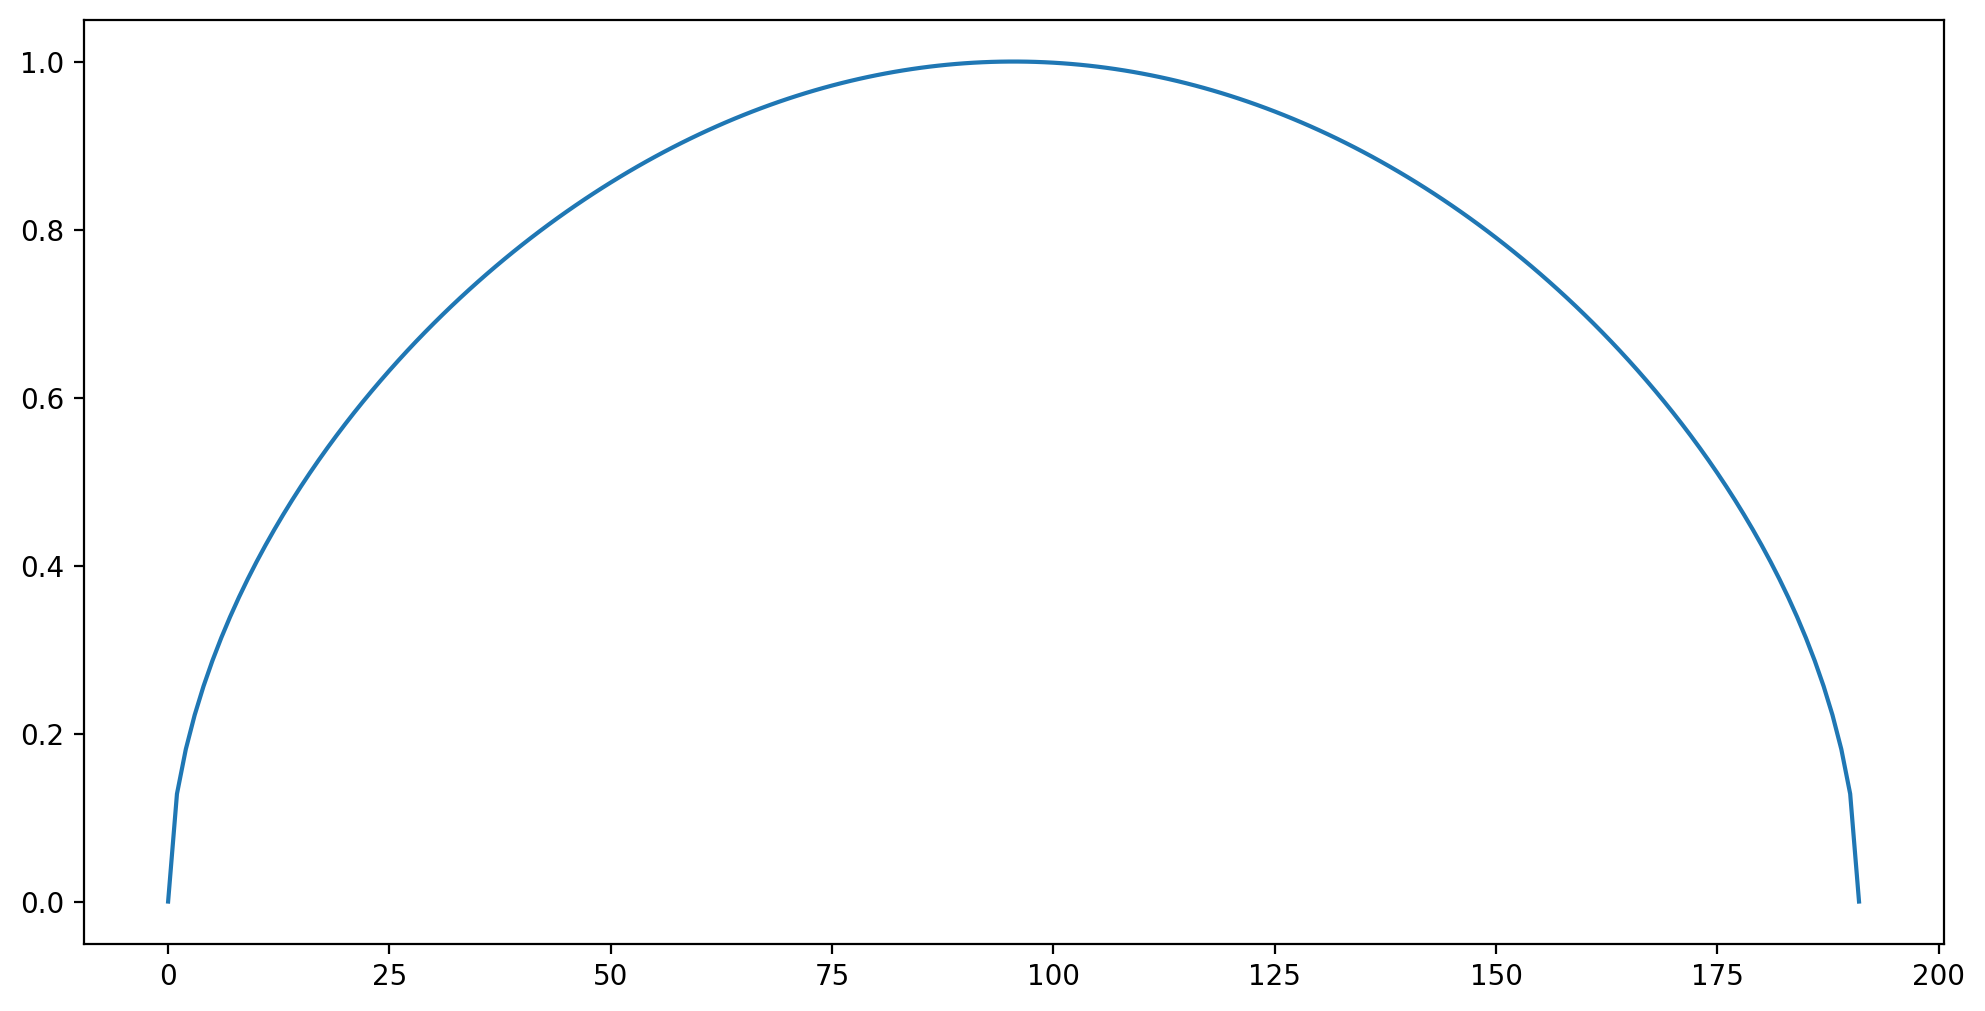

In [61]:
coslat = np.expand_dims( np.cos(ds_tas_his.lat.values * np.pi/180)**(0.5),1)
plt.plot(coslat)

In [62]:
# Reshape into (N_t, 55296)
N_t, N_lat, N_lon = T.shape
X = (T*coslat).reshape(N_t, N_lat * N_lon)
Y = (TPW*coslat).reshape(N_t, N_lat * N_lon)
# Standardize (zero-mean across time)
X_centered = np.zeros_like(X)
Y_centered = np.zeros_like(Y)

for i in range(12):
    X_centered[i::12,:] = X[i::12,:] - X[i::12,:].mean(axis=0)
    Y_centered[i::12,:] = Y[i::12,:] - Y[i::12,:].mean(axis=0)
# Apply PCA
pca_X = PCA(n_components=24)  # Retain top 50 components
X_reduced = pca_X.fit_transform(X_centered)
X_proj = pca_X.transform(X_centered)
pca_Y = PCA(n_components=24)  # Retain top 50 components
Y_reduced = pca_Y.fit_transform(Y_centered)
Y_proj = pca_Y.transform(Y_centered)

# Explained variance
explained_variance_X = pca_X.explained_variance_ratio_.sum()
print(f"Total variance explained by top 4 PCs (X): {explained_variance_X:.2%}")
explained_variance_Y = pca_Y.explained_variance_ratio_.sum()
print(f"Total variance explained by top 4 PCs (Log(Y)): {explained_variance_Y:.2%}")
# Principal component time series (X_reduced) now has shape (N_t, 4)

Total variance explained by top 4 PCs (X): 65.79%
Total variance explained by top 4 PCs (Log(Y)): 56.96%


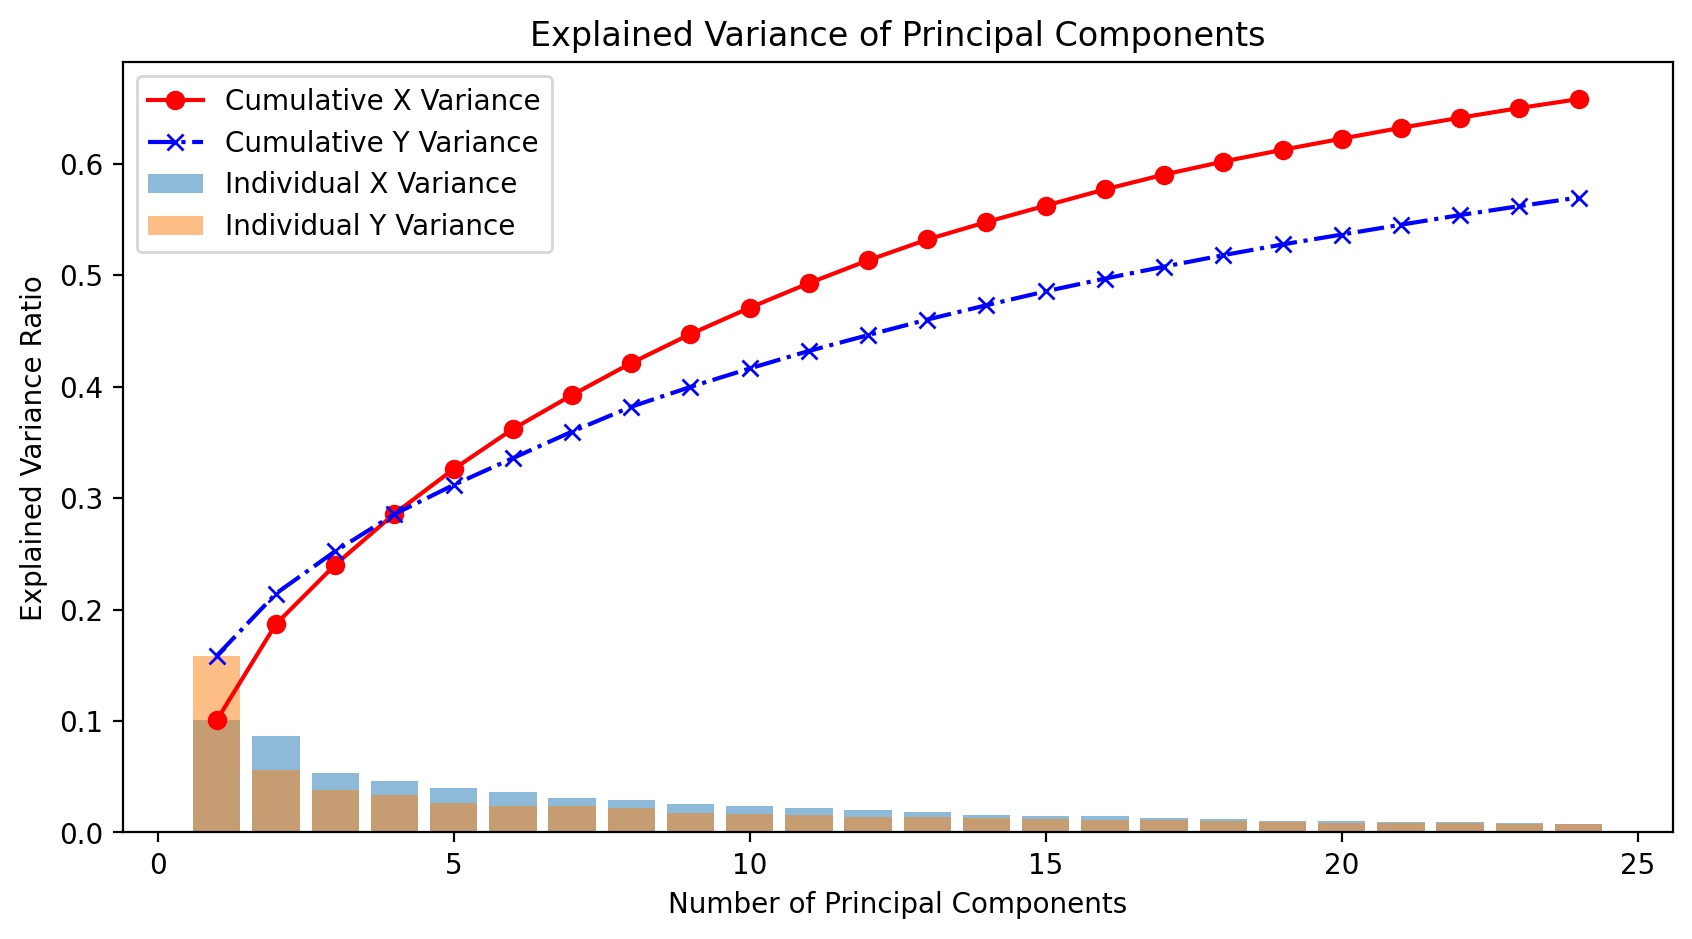

In [63]:
explained_variance_ratio_X = pca_X.explained_variance_ratio_
cumulative_variance_X = np.cumsum(explained_variance_ratio_X)

explained_variance_ratio_Y = pca_Y.explained_variance_ratio_
cumulative_variance_Y = np.cumsum(explained_variance_ratio_Y)

plt.figure(figsize=(10, 5))
plt.bar(range(1, 25), explained_variance_ratio_X[:24], alpha=0.5, label="Individual X Variance")
plt.plot(range(1, 25), cumulative_variance_X[:24], marker='o', linestyle='-', color='r', label="Cumulative X Variance")
plt.bar(range(1, 25), explained_variance_ratio_Y[:24], alpha=0.5, label="Individual Y Variance")
plt.plot(range(1, 25), cumulative_variance_Y[:24], marker='x', linestyle='-.', color='b', label="Cumulative Y Variance")

plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance of Principal Components")
plt.legend()
plt.show()

(24, 55296)


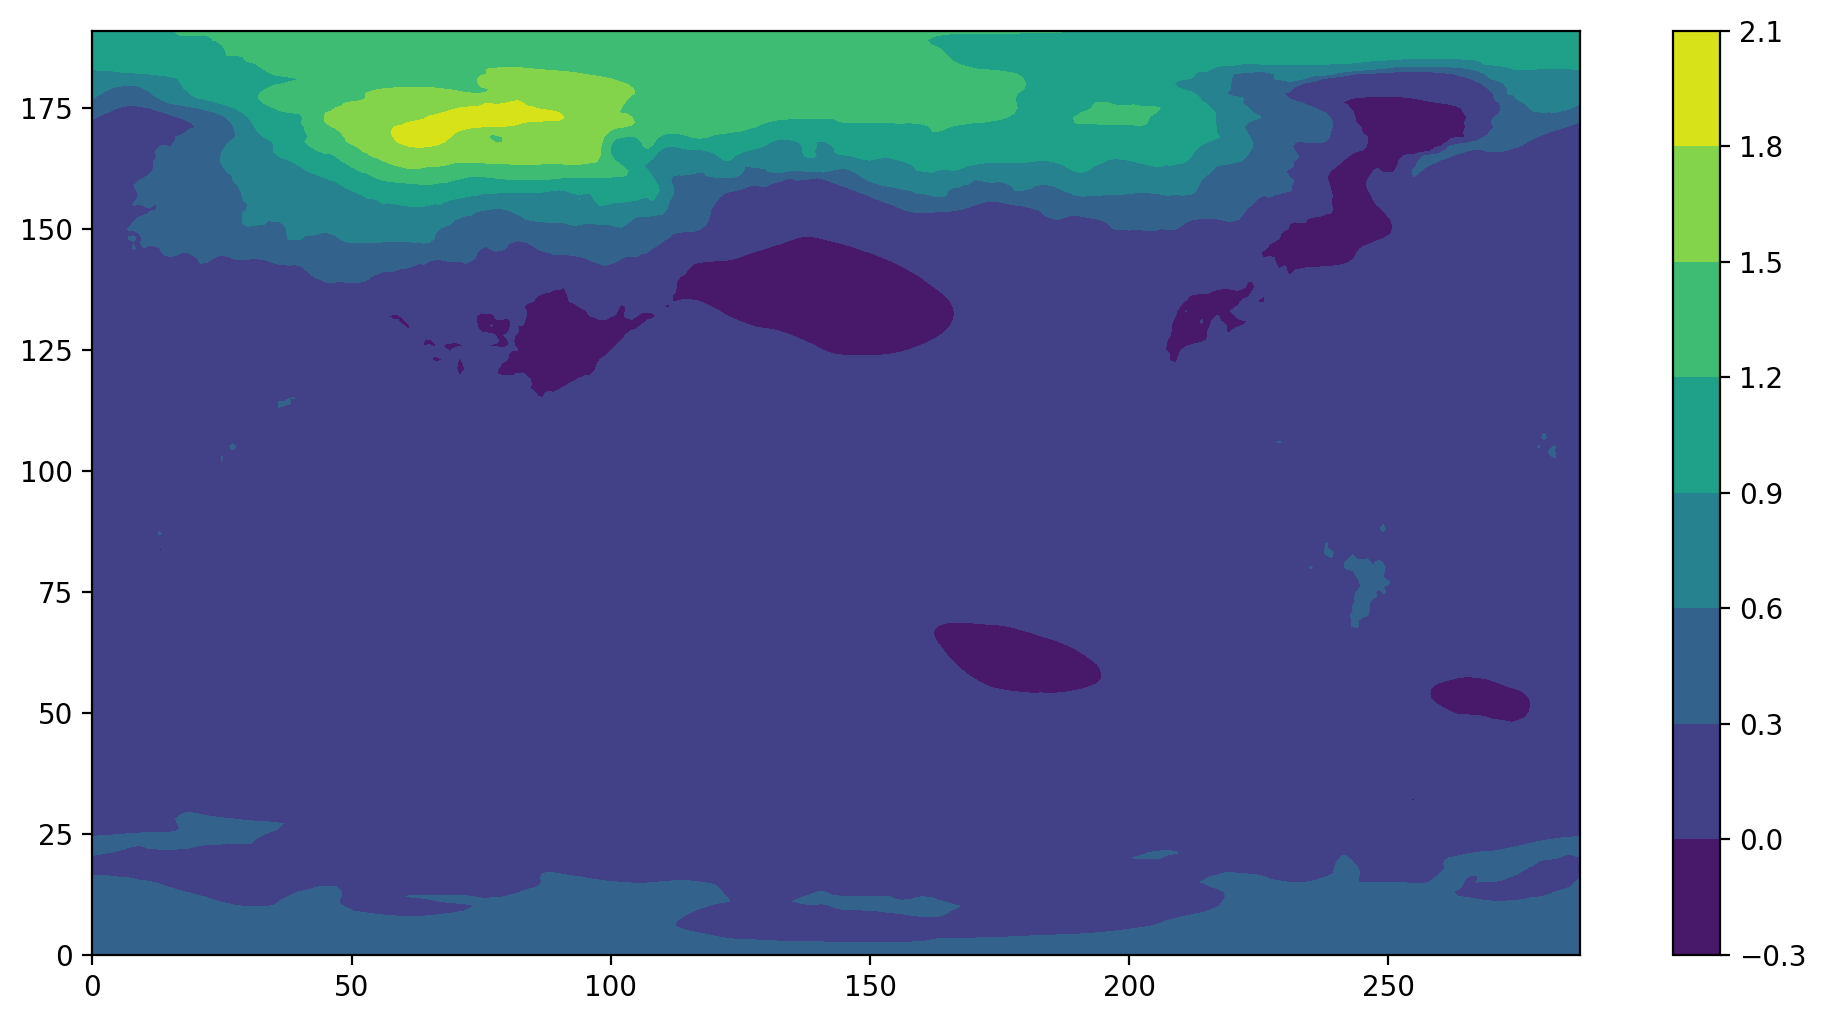

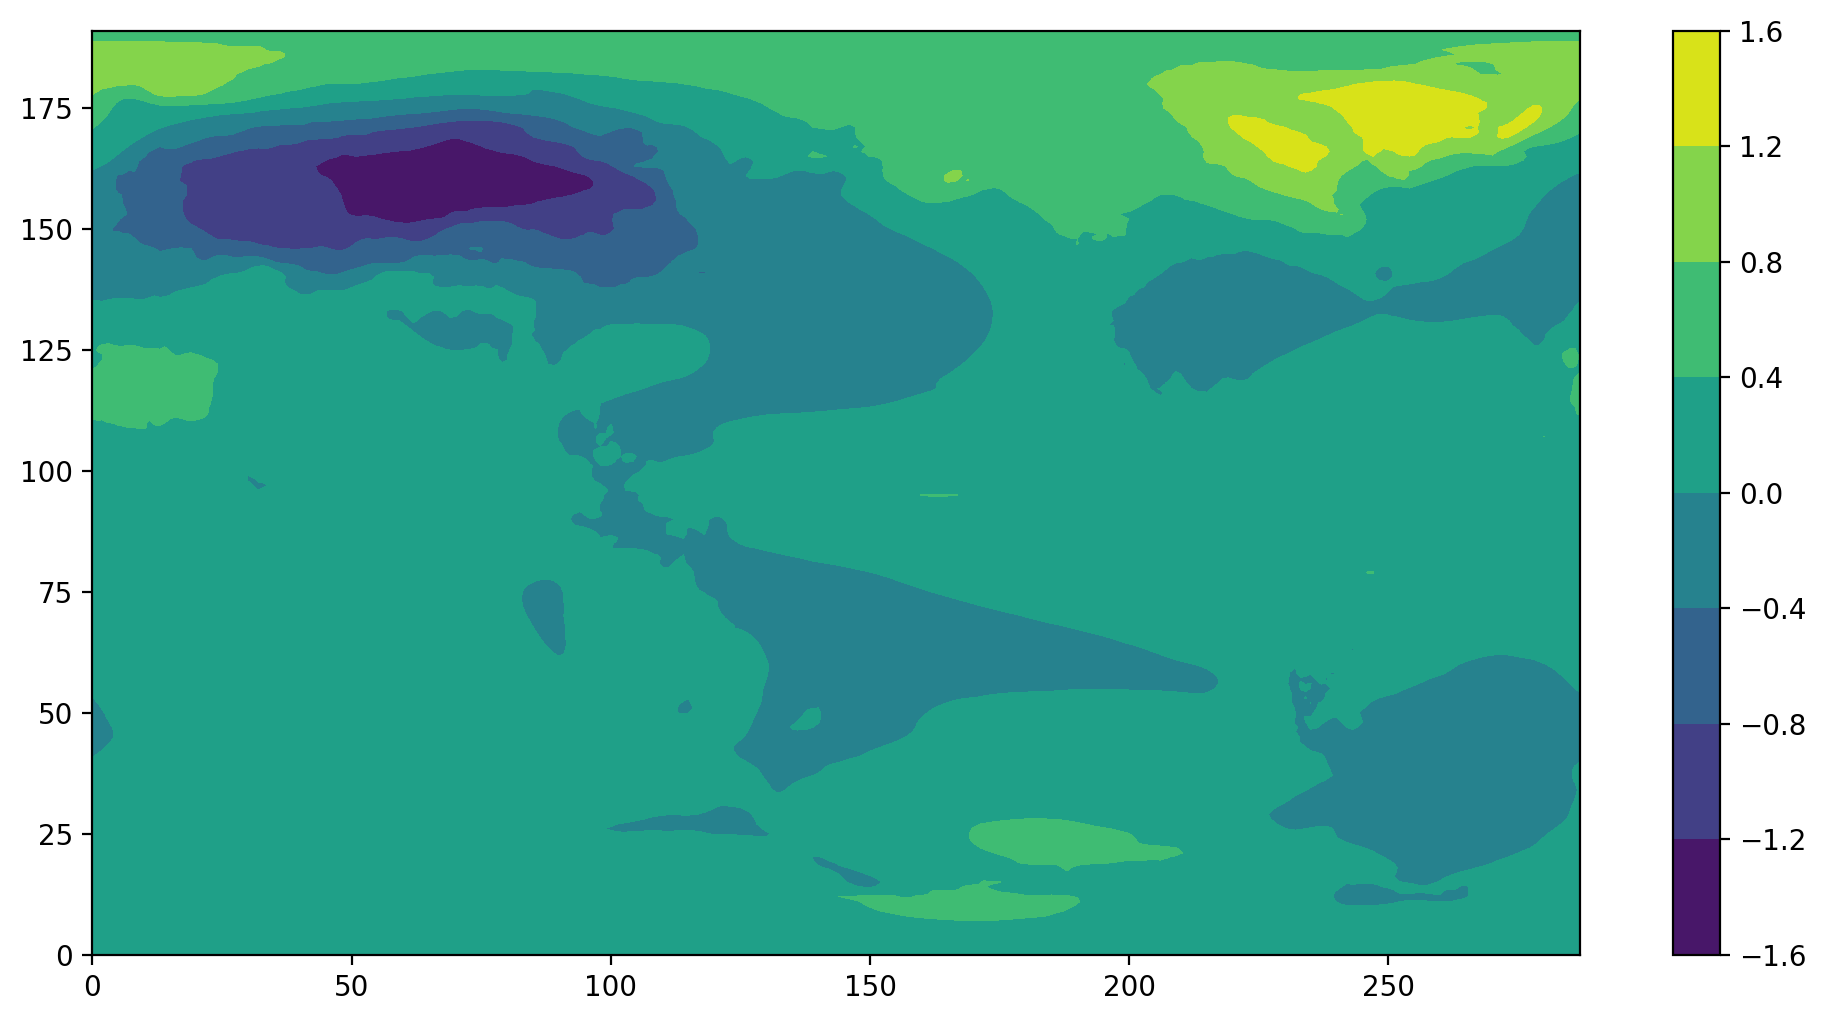

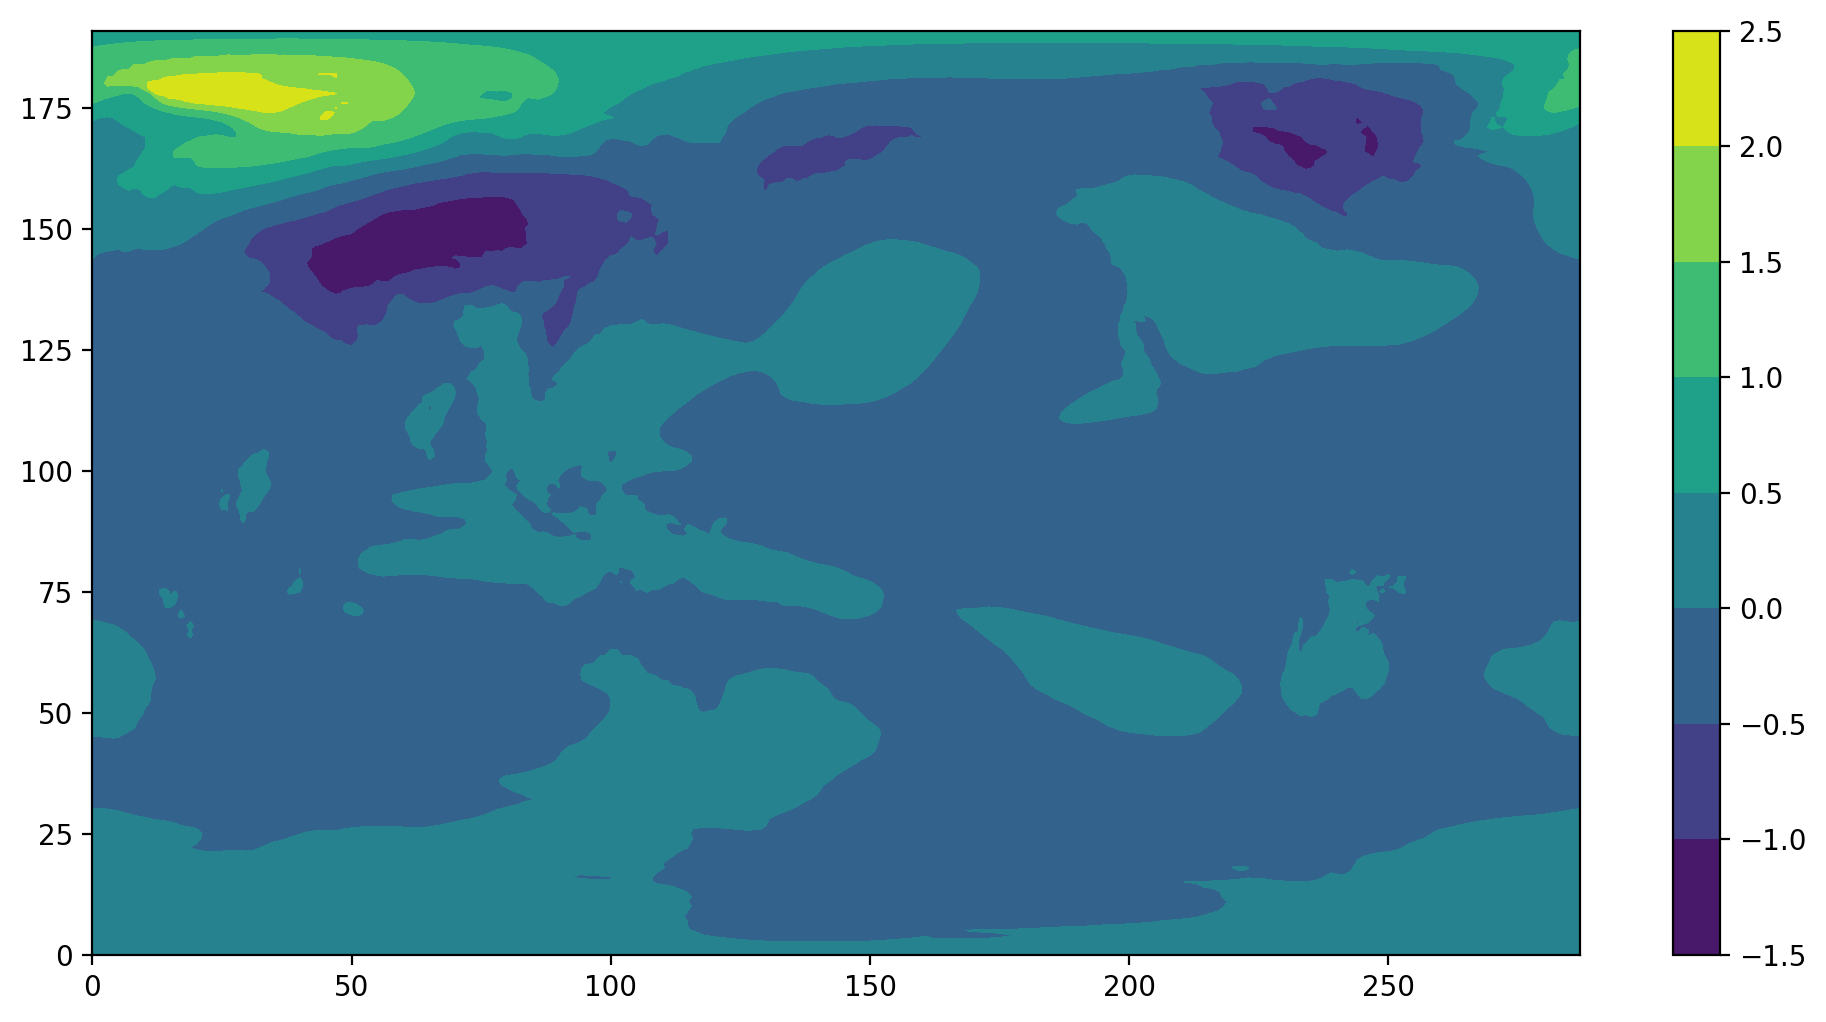

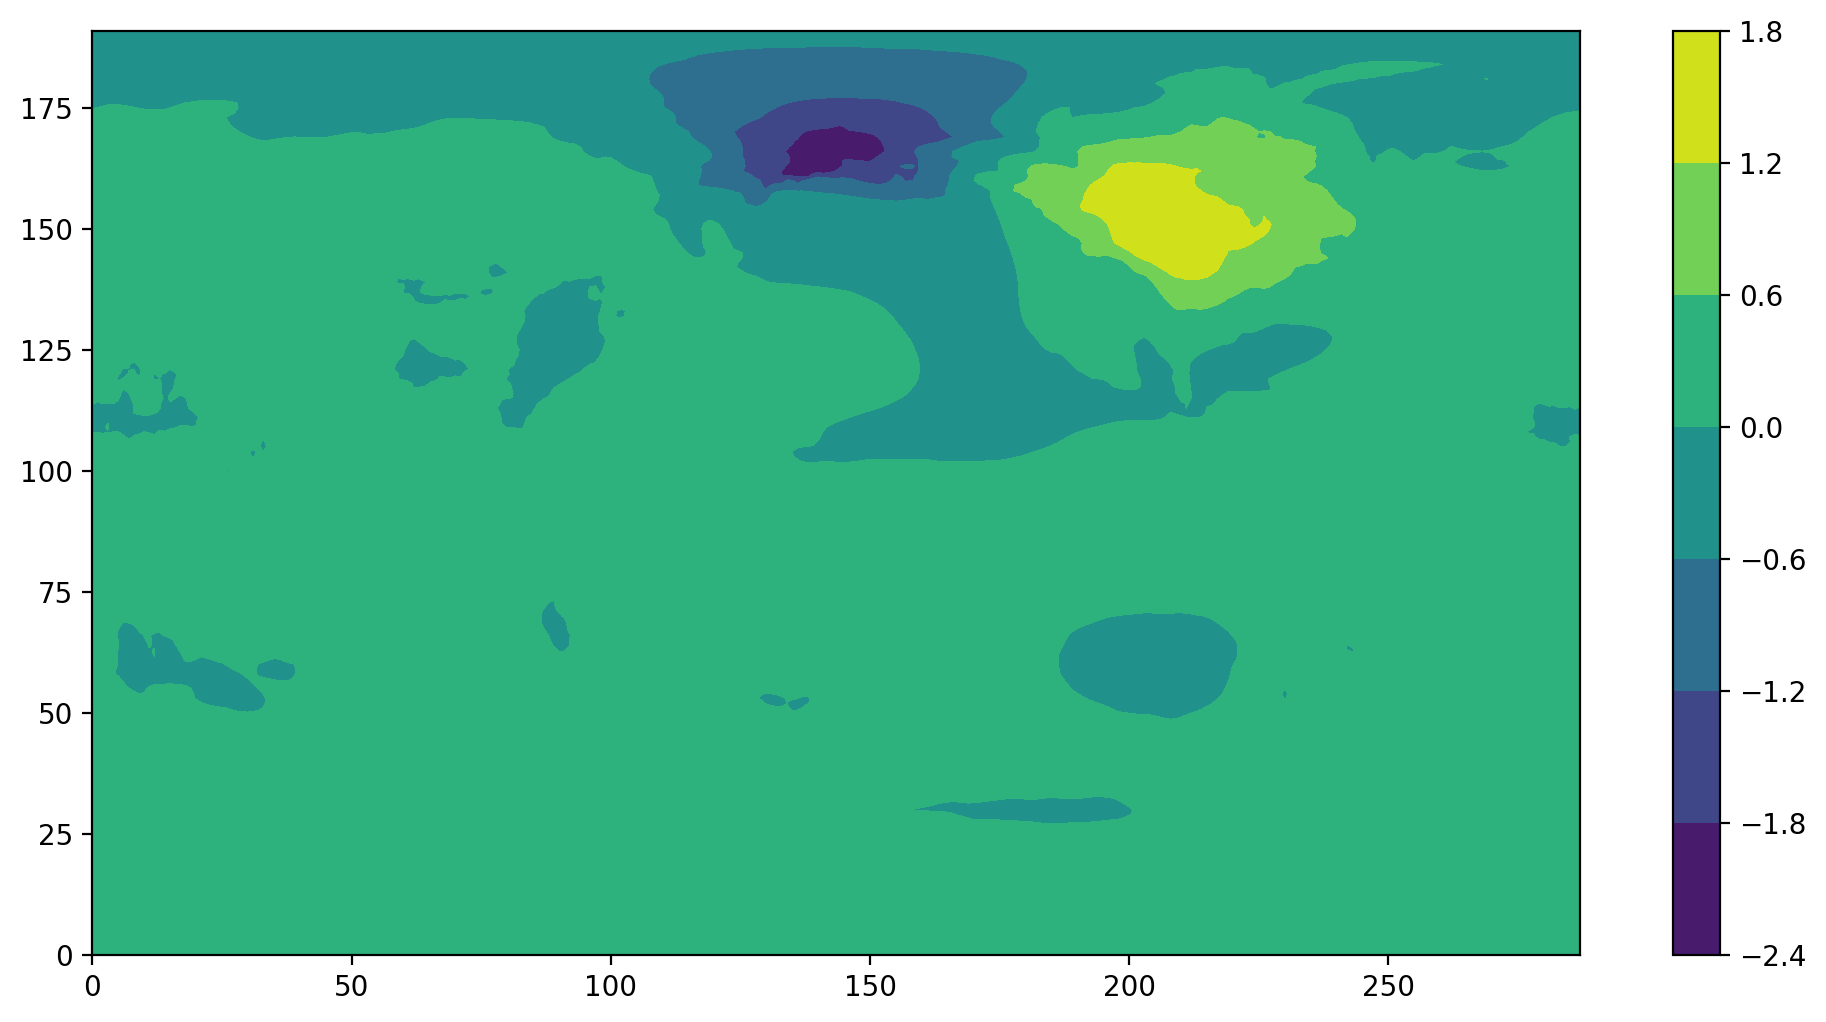

In [70]:
print(pca_X.components_.shape)
for i in range(4):
    plt.contourf(pca_X.singular_values_[i]**(0.5) * pca_X.components_[i,:].reshape((192,288))/coslat)
    plt.colorbar()
    plt.show()

(1980, 24)
PCA - temperature  1


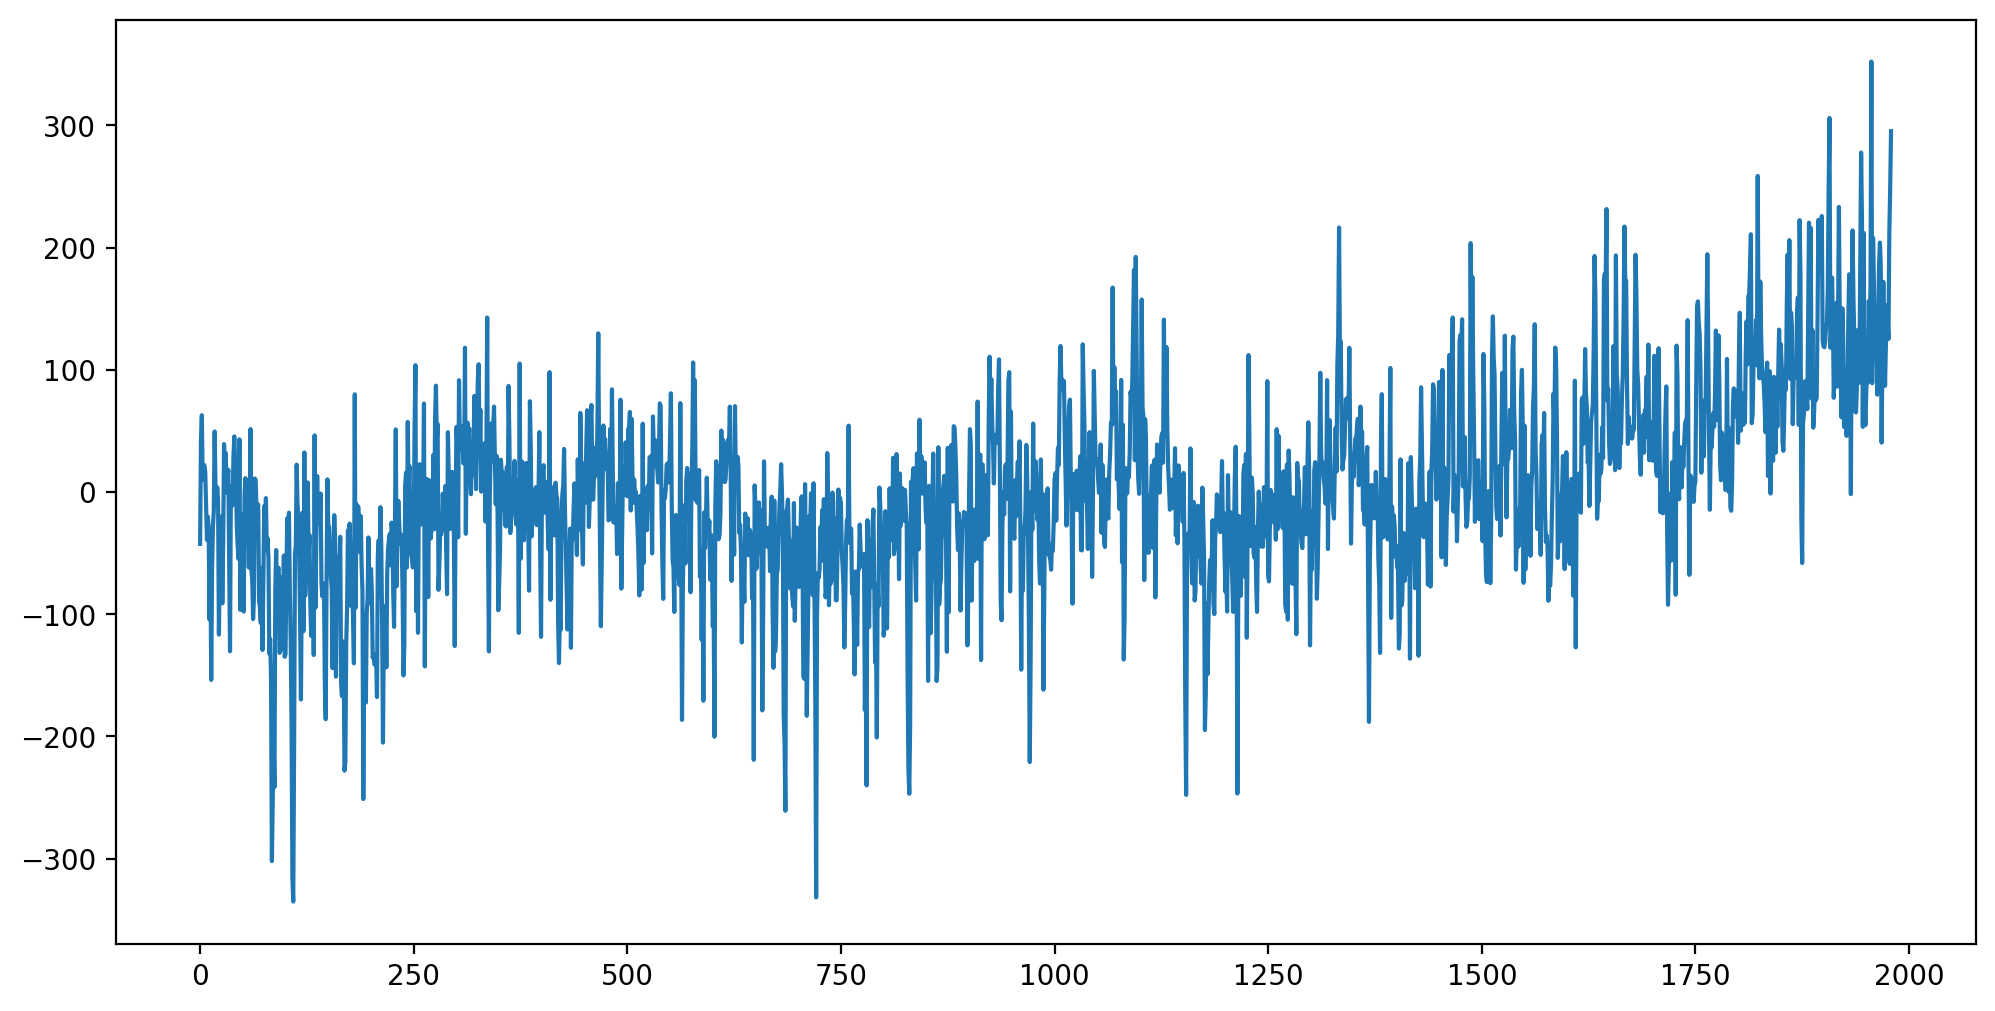

PCA - temperature  2


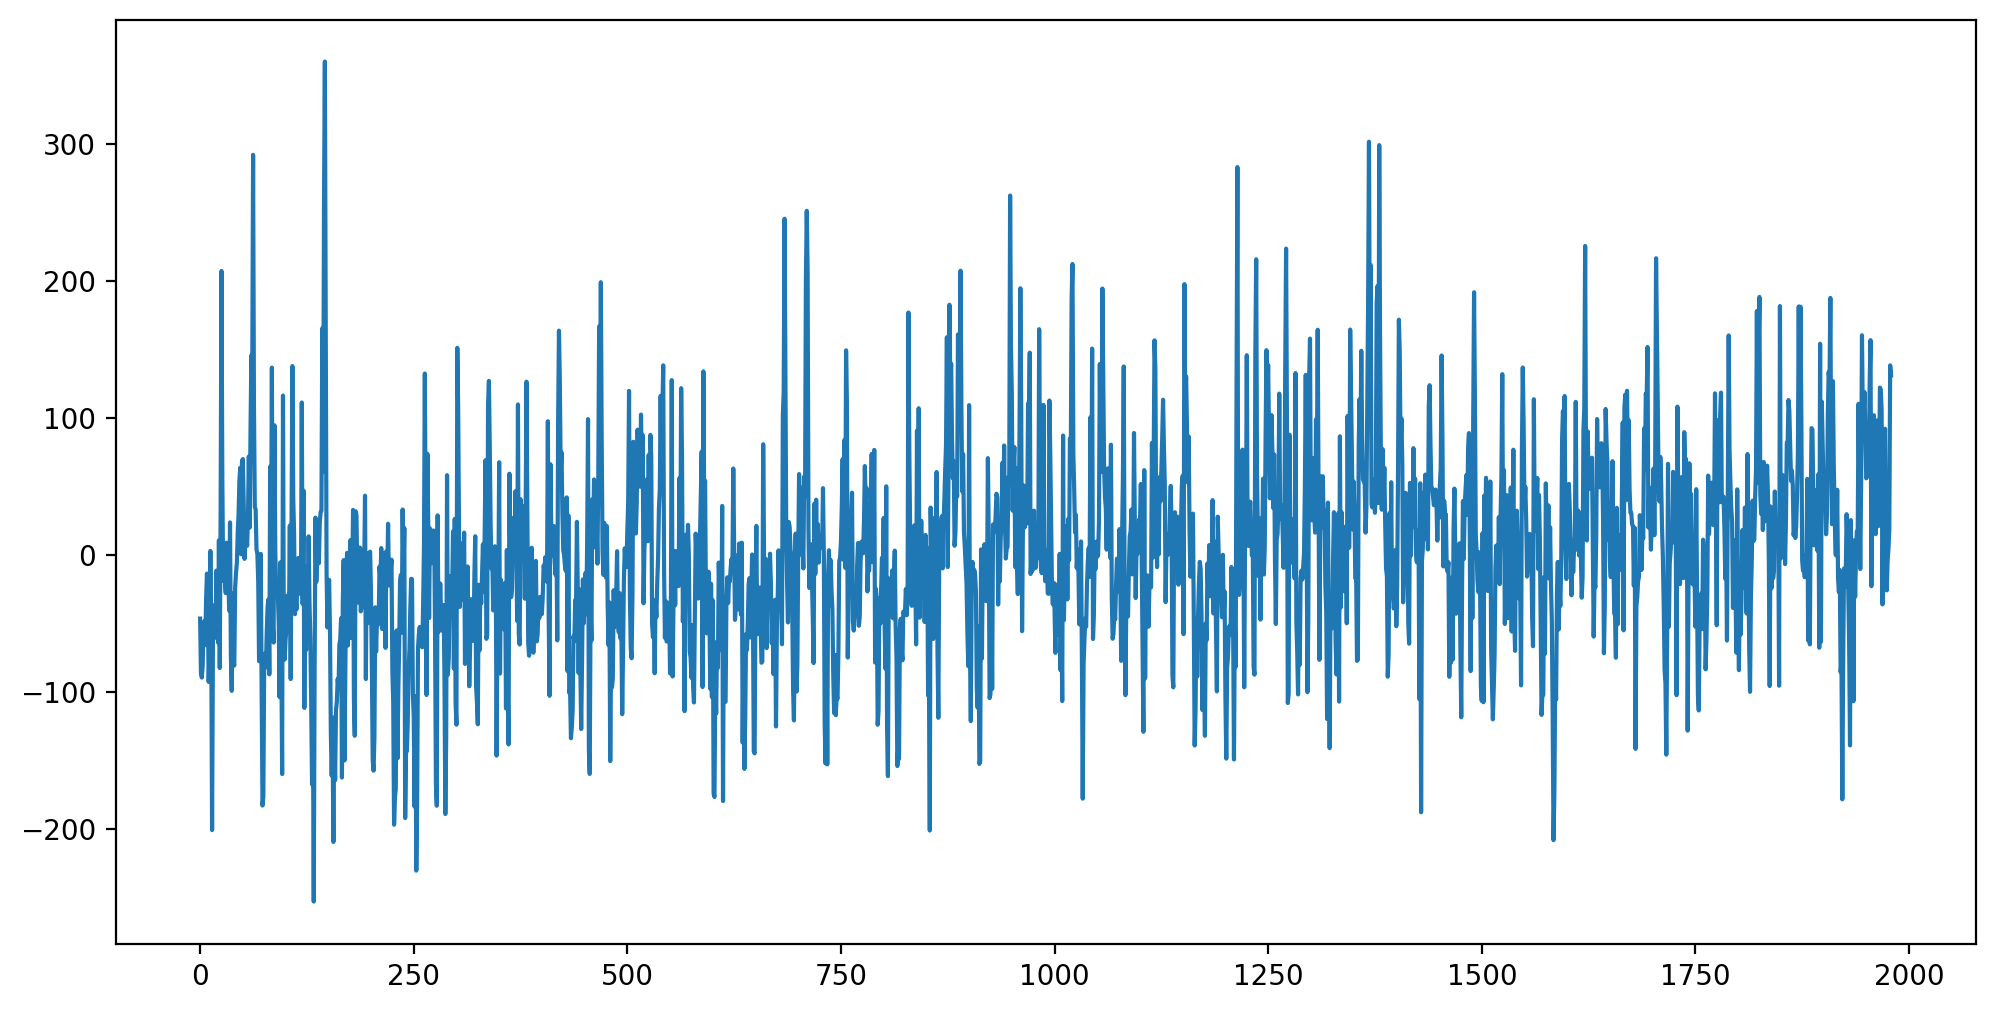

PCA - temperature  3


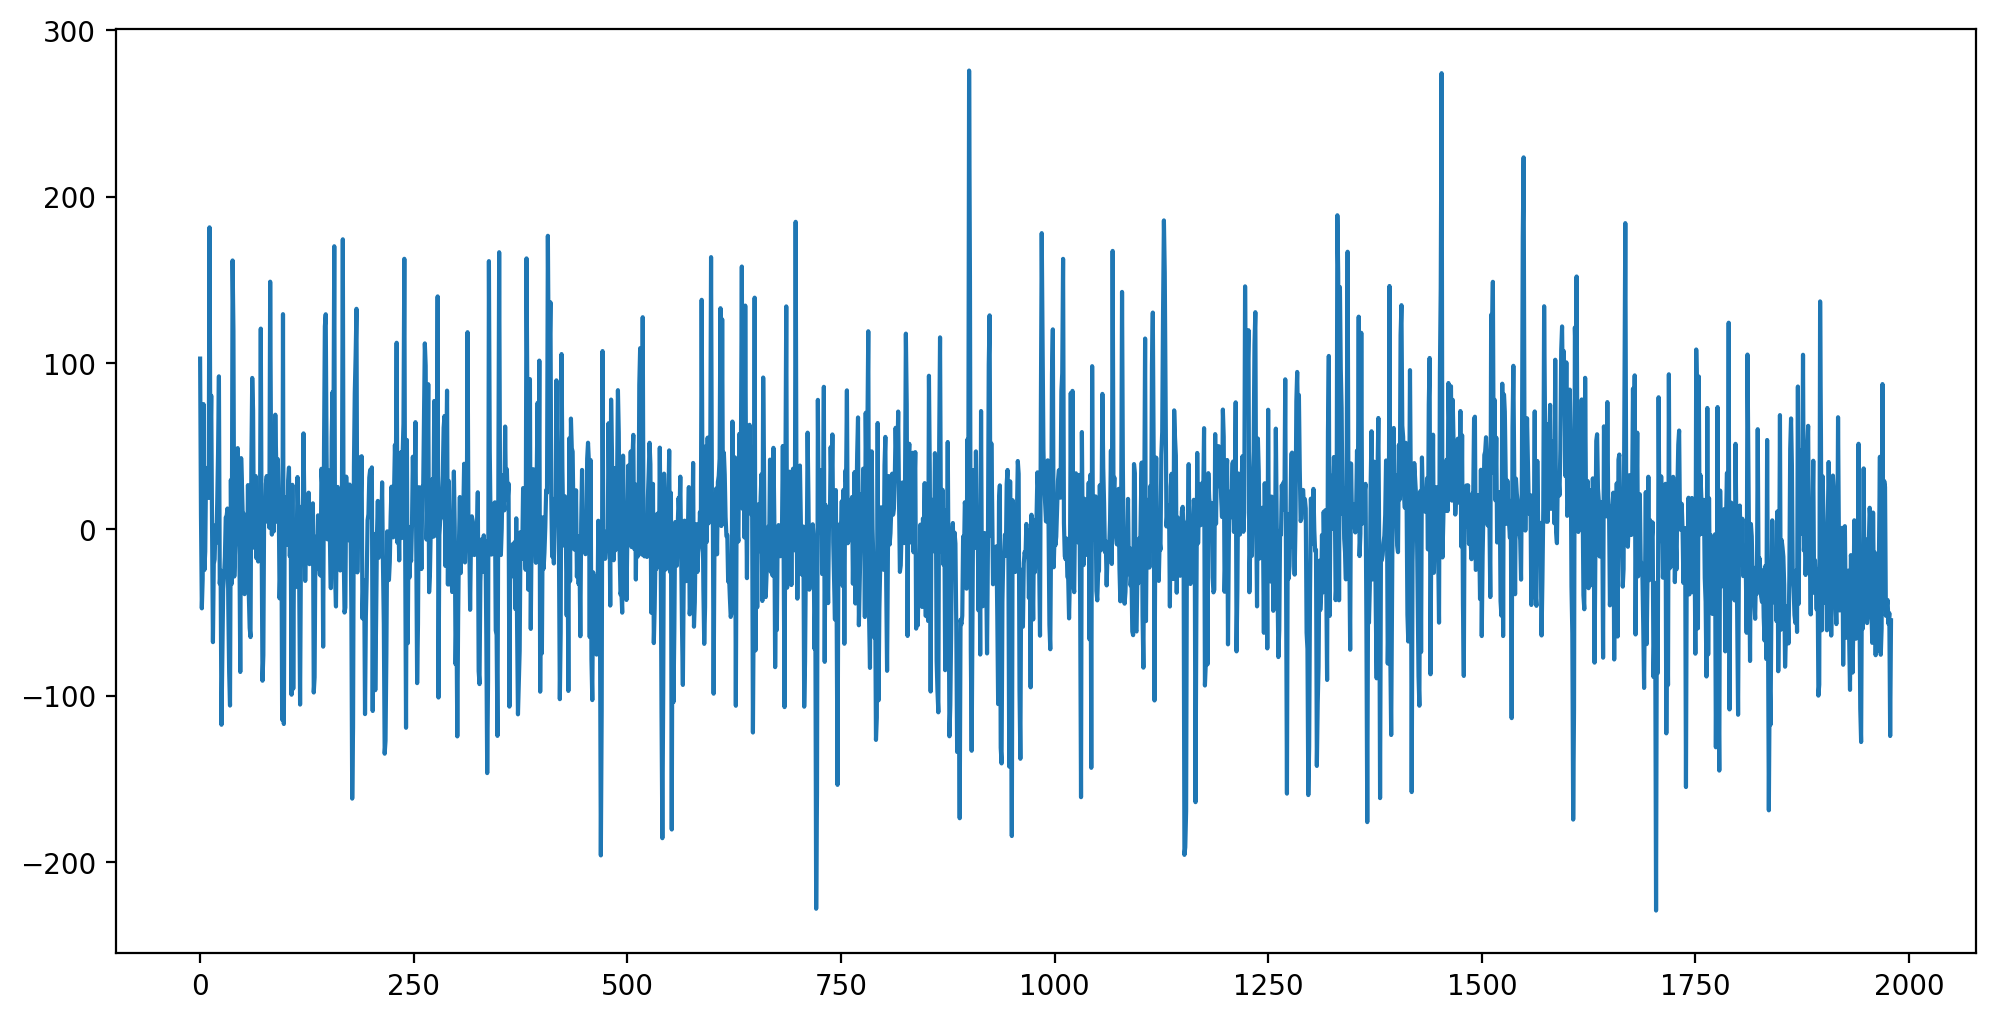

PCA - temperature  4


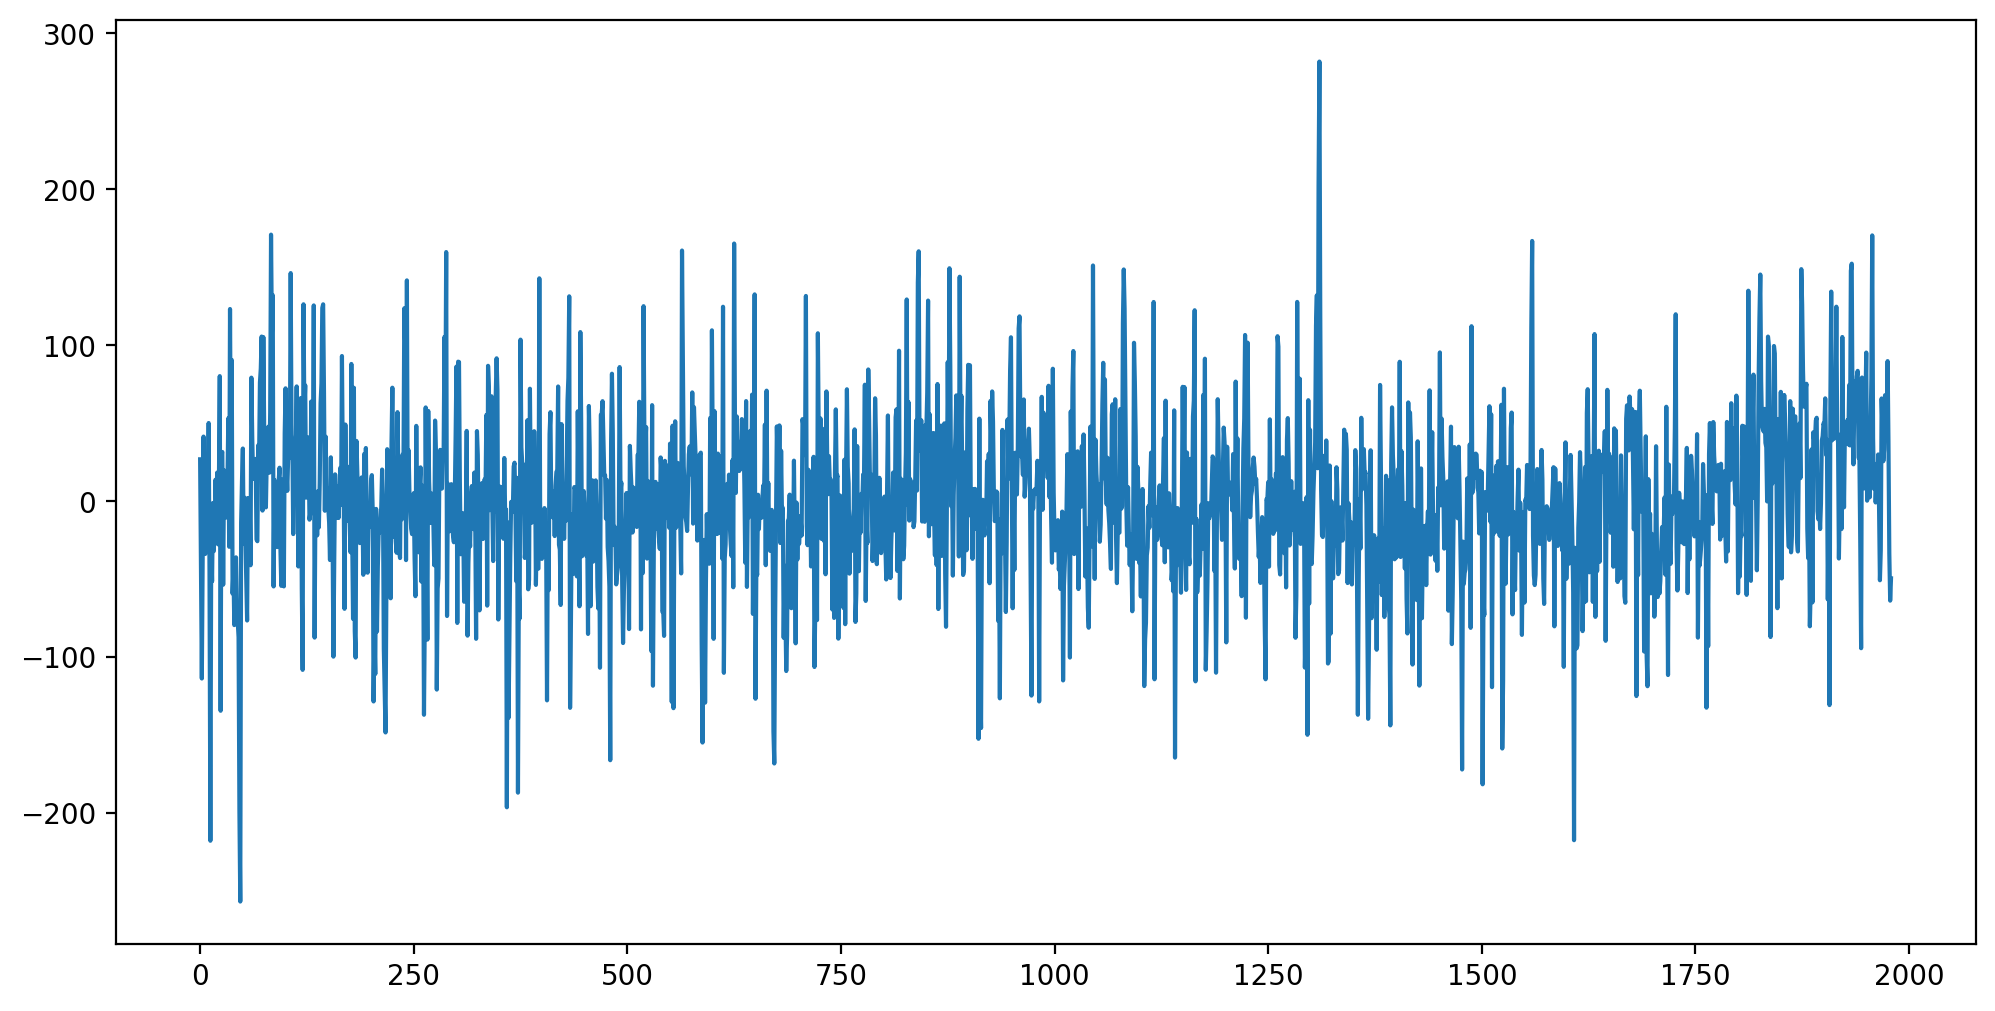

PCA - temperature  5


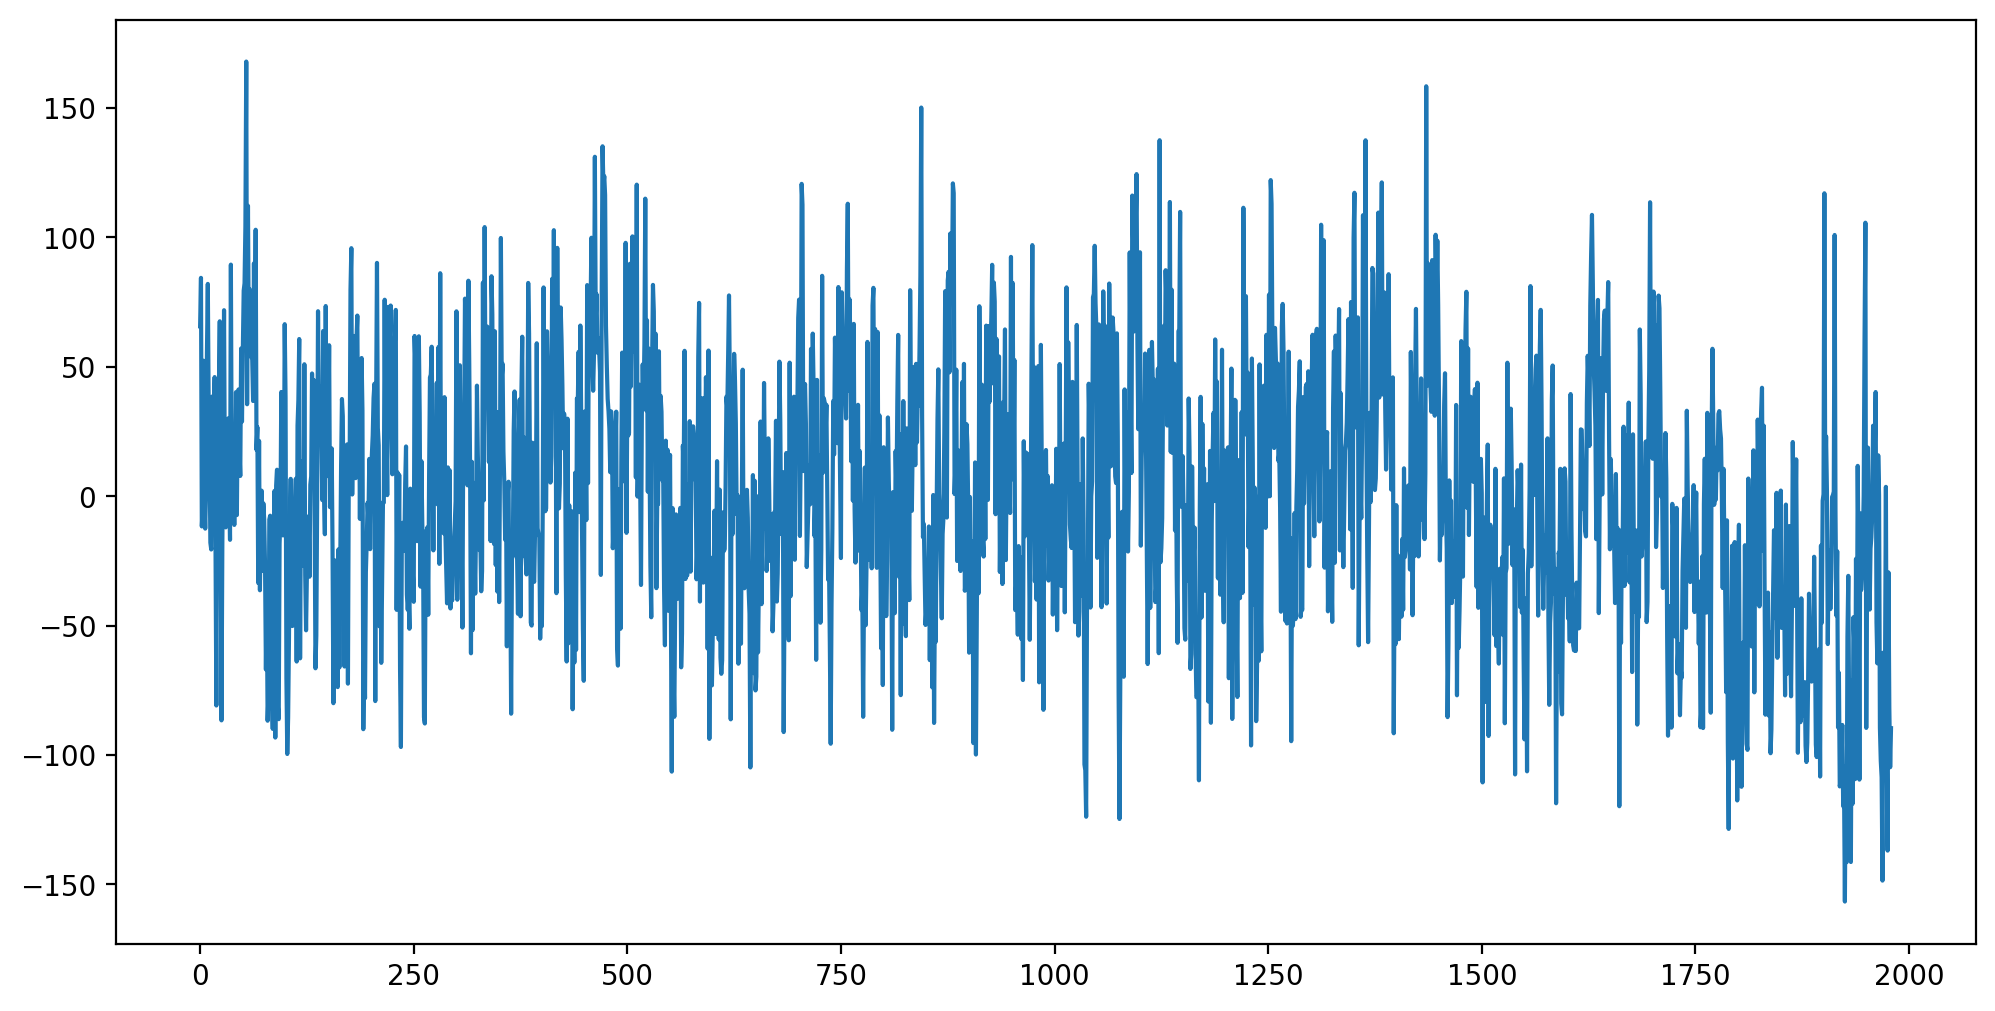

PCA - temperature  6


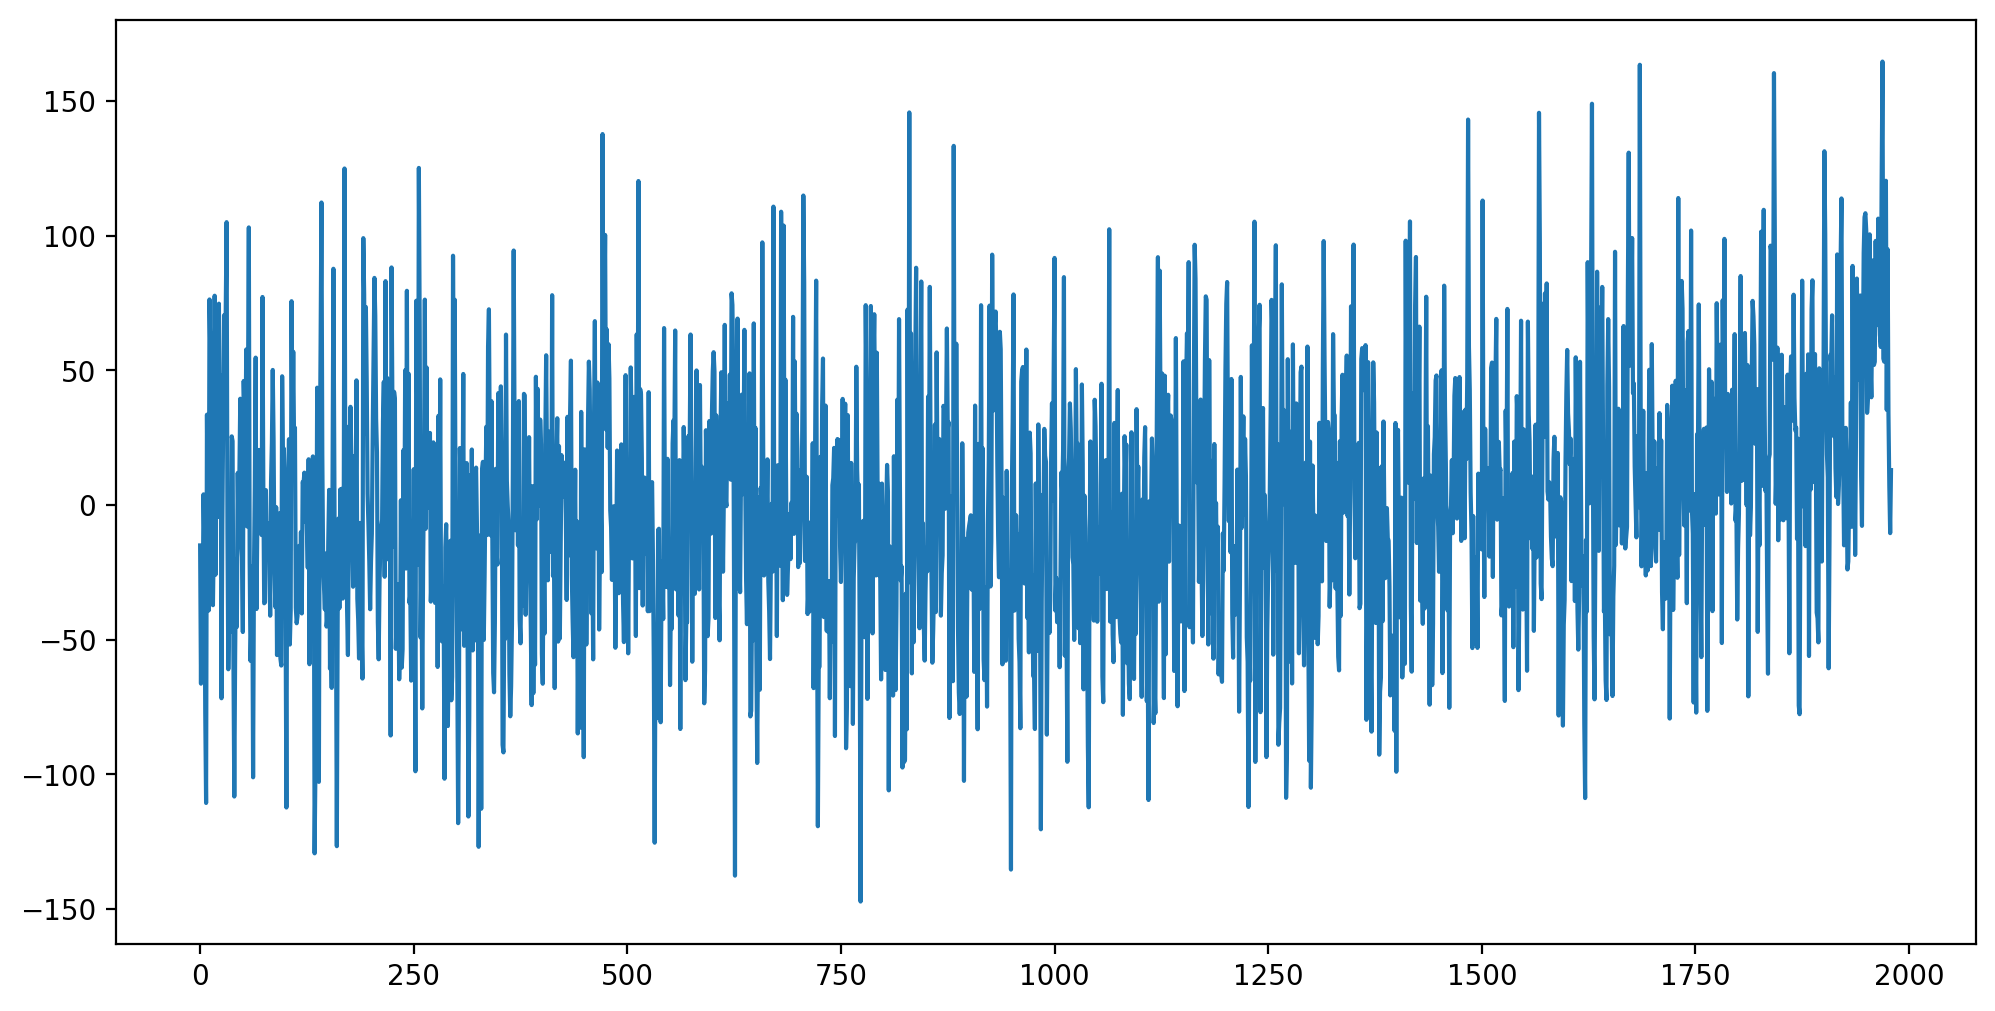

PCA - TCW  1


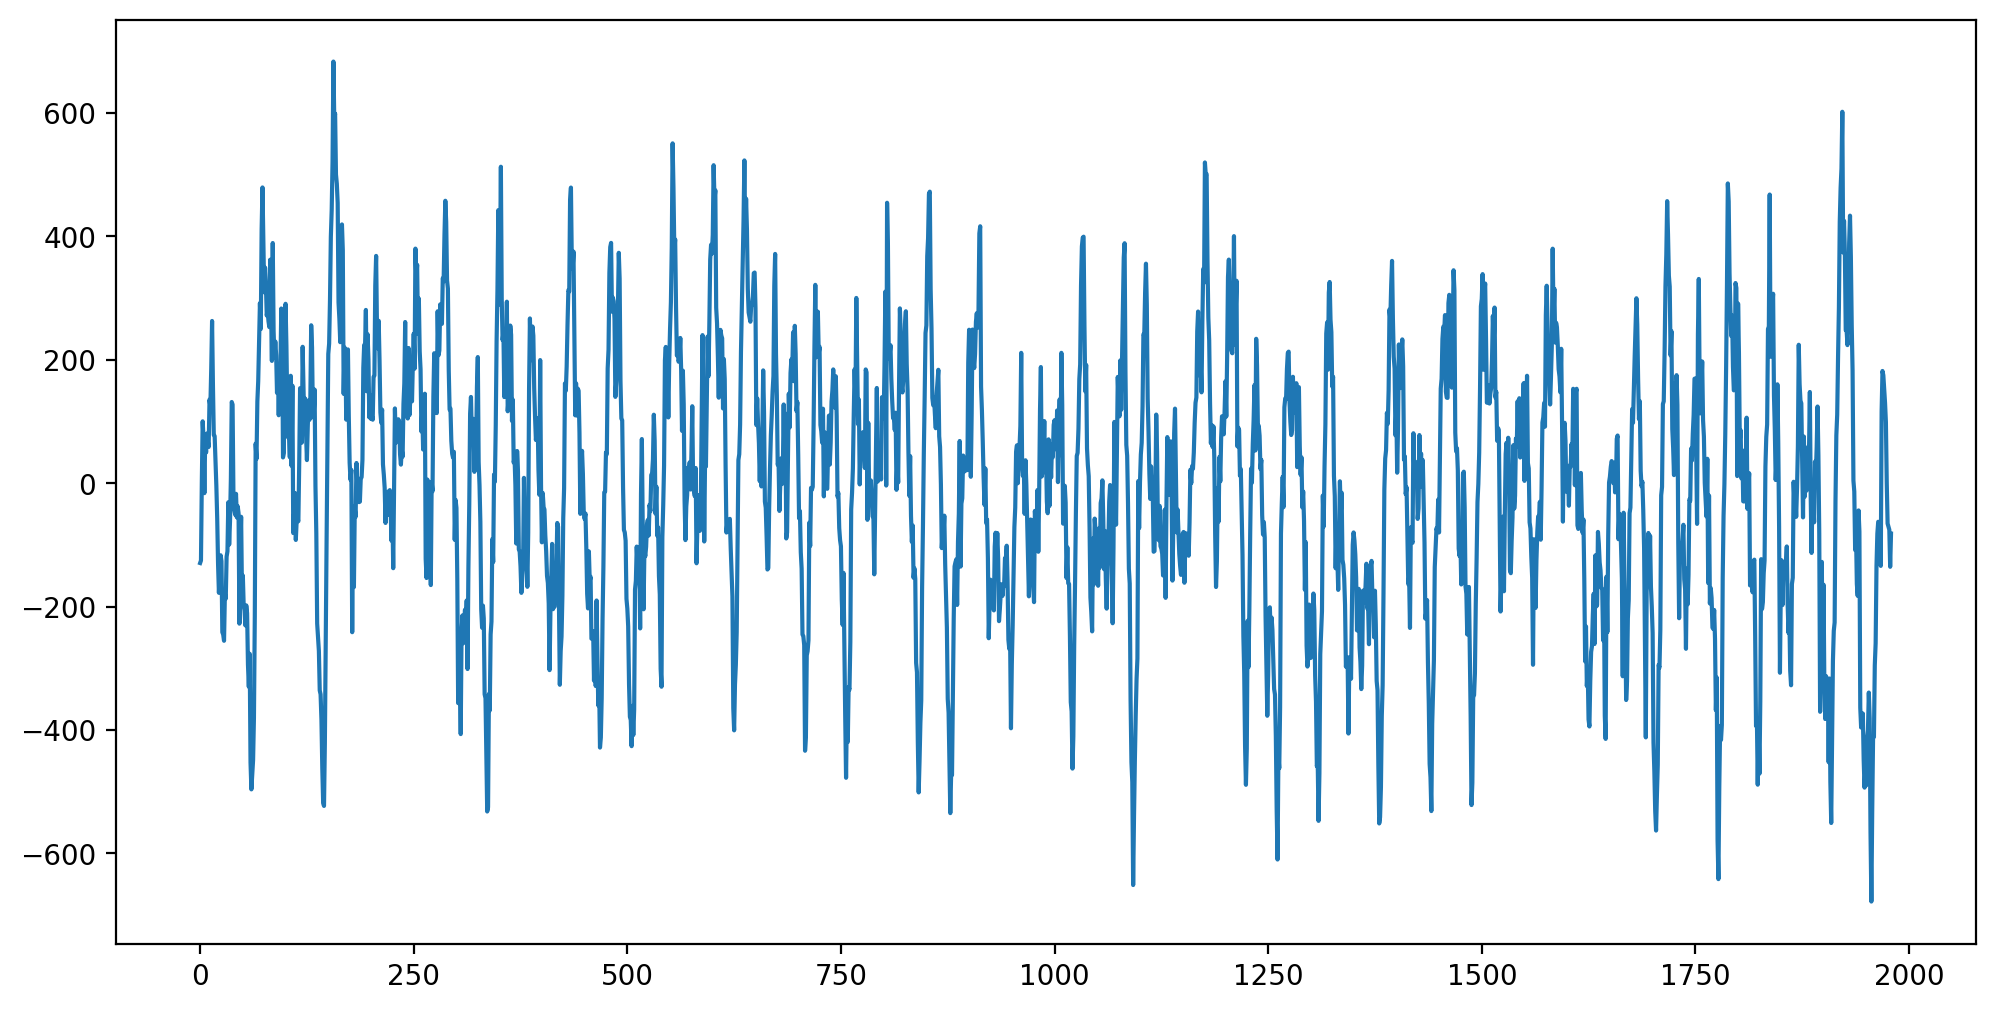

PCA - TCW  2


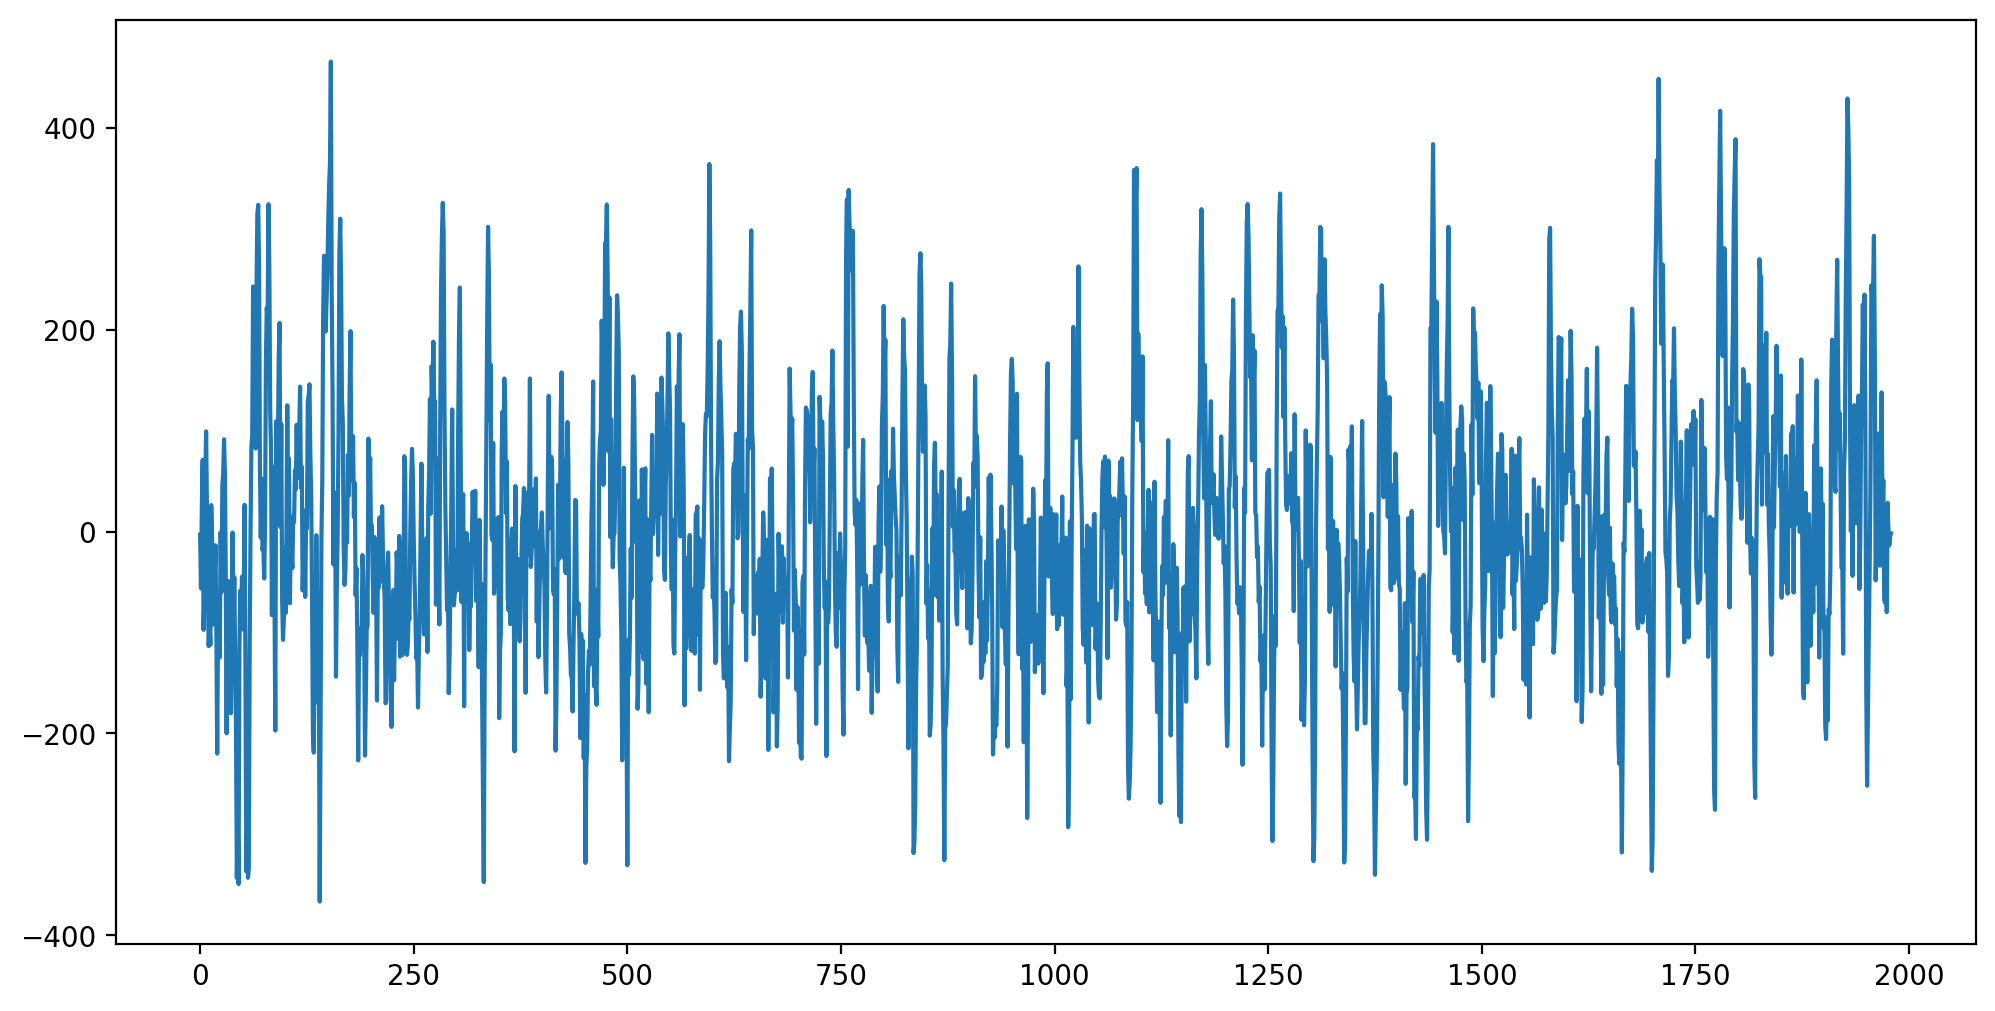

PCA - TCW  3


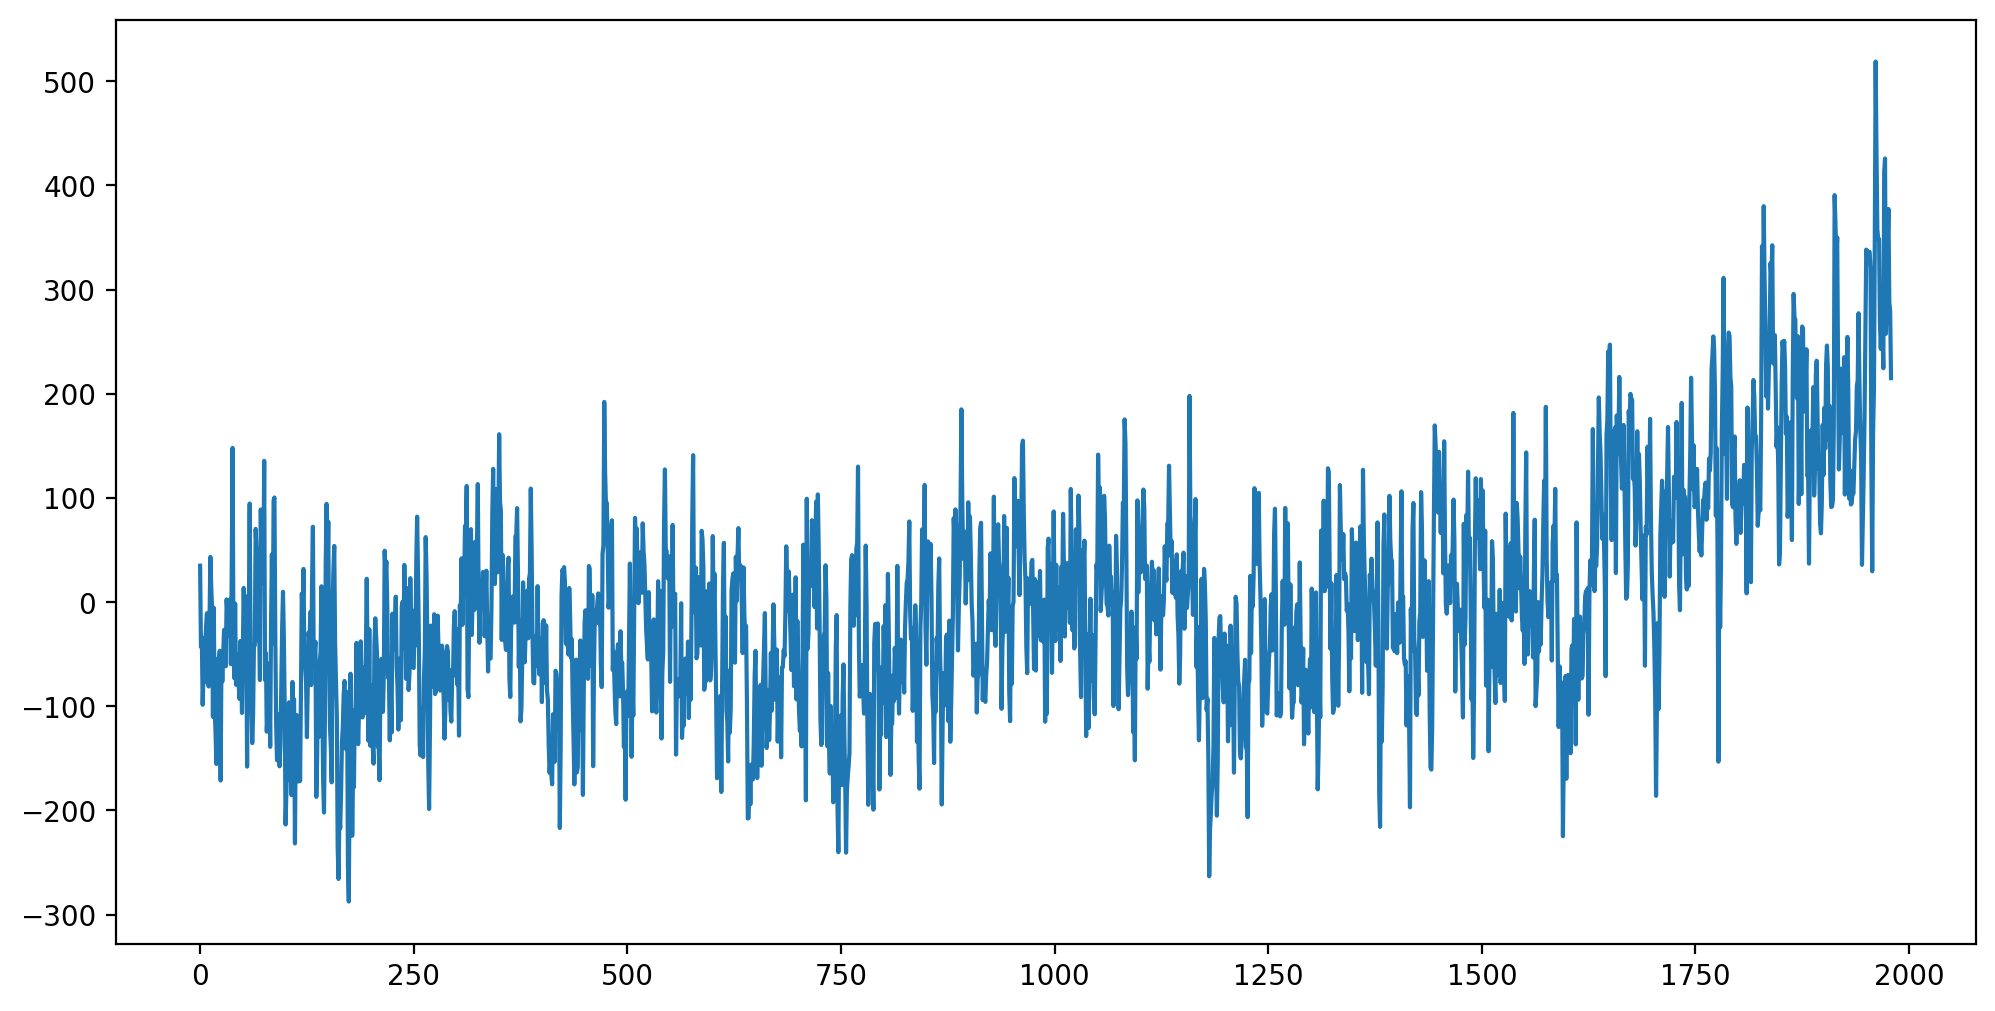

PCA - TCW  4


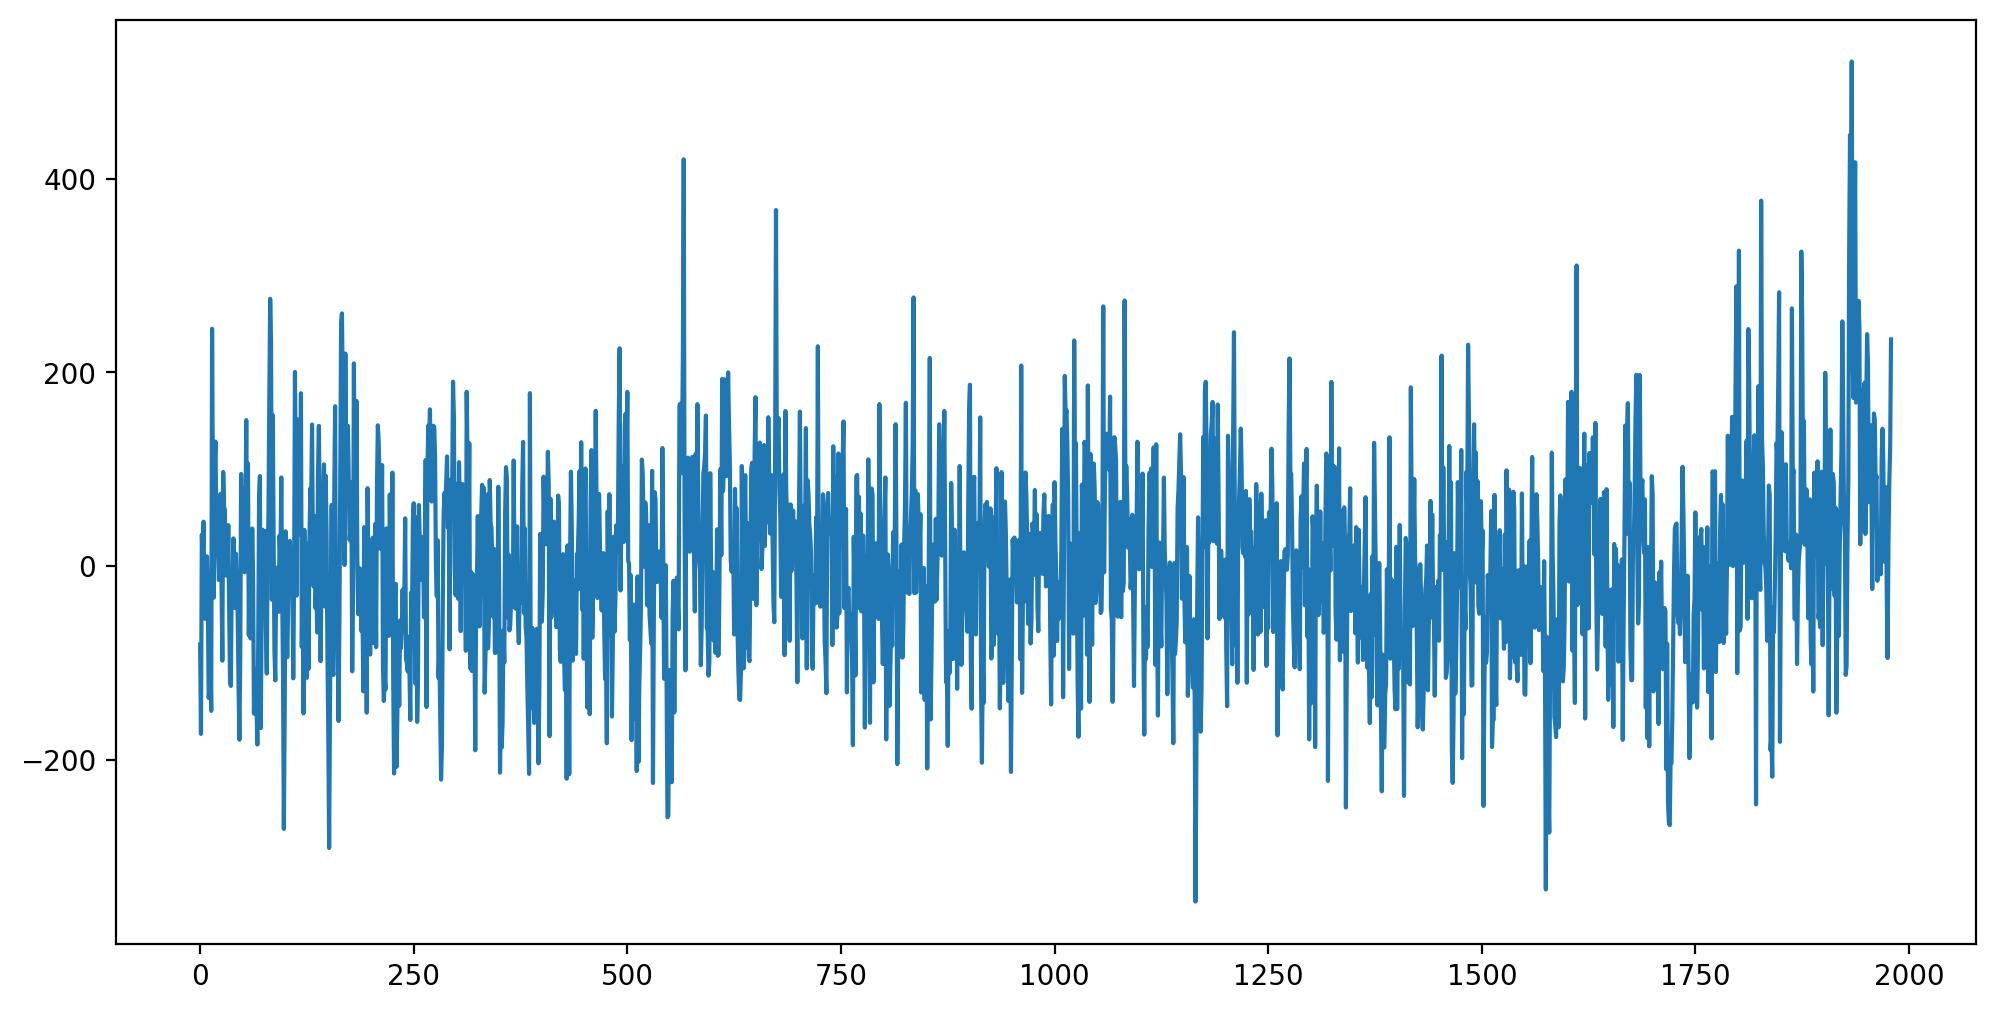

PCA - TCW  5


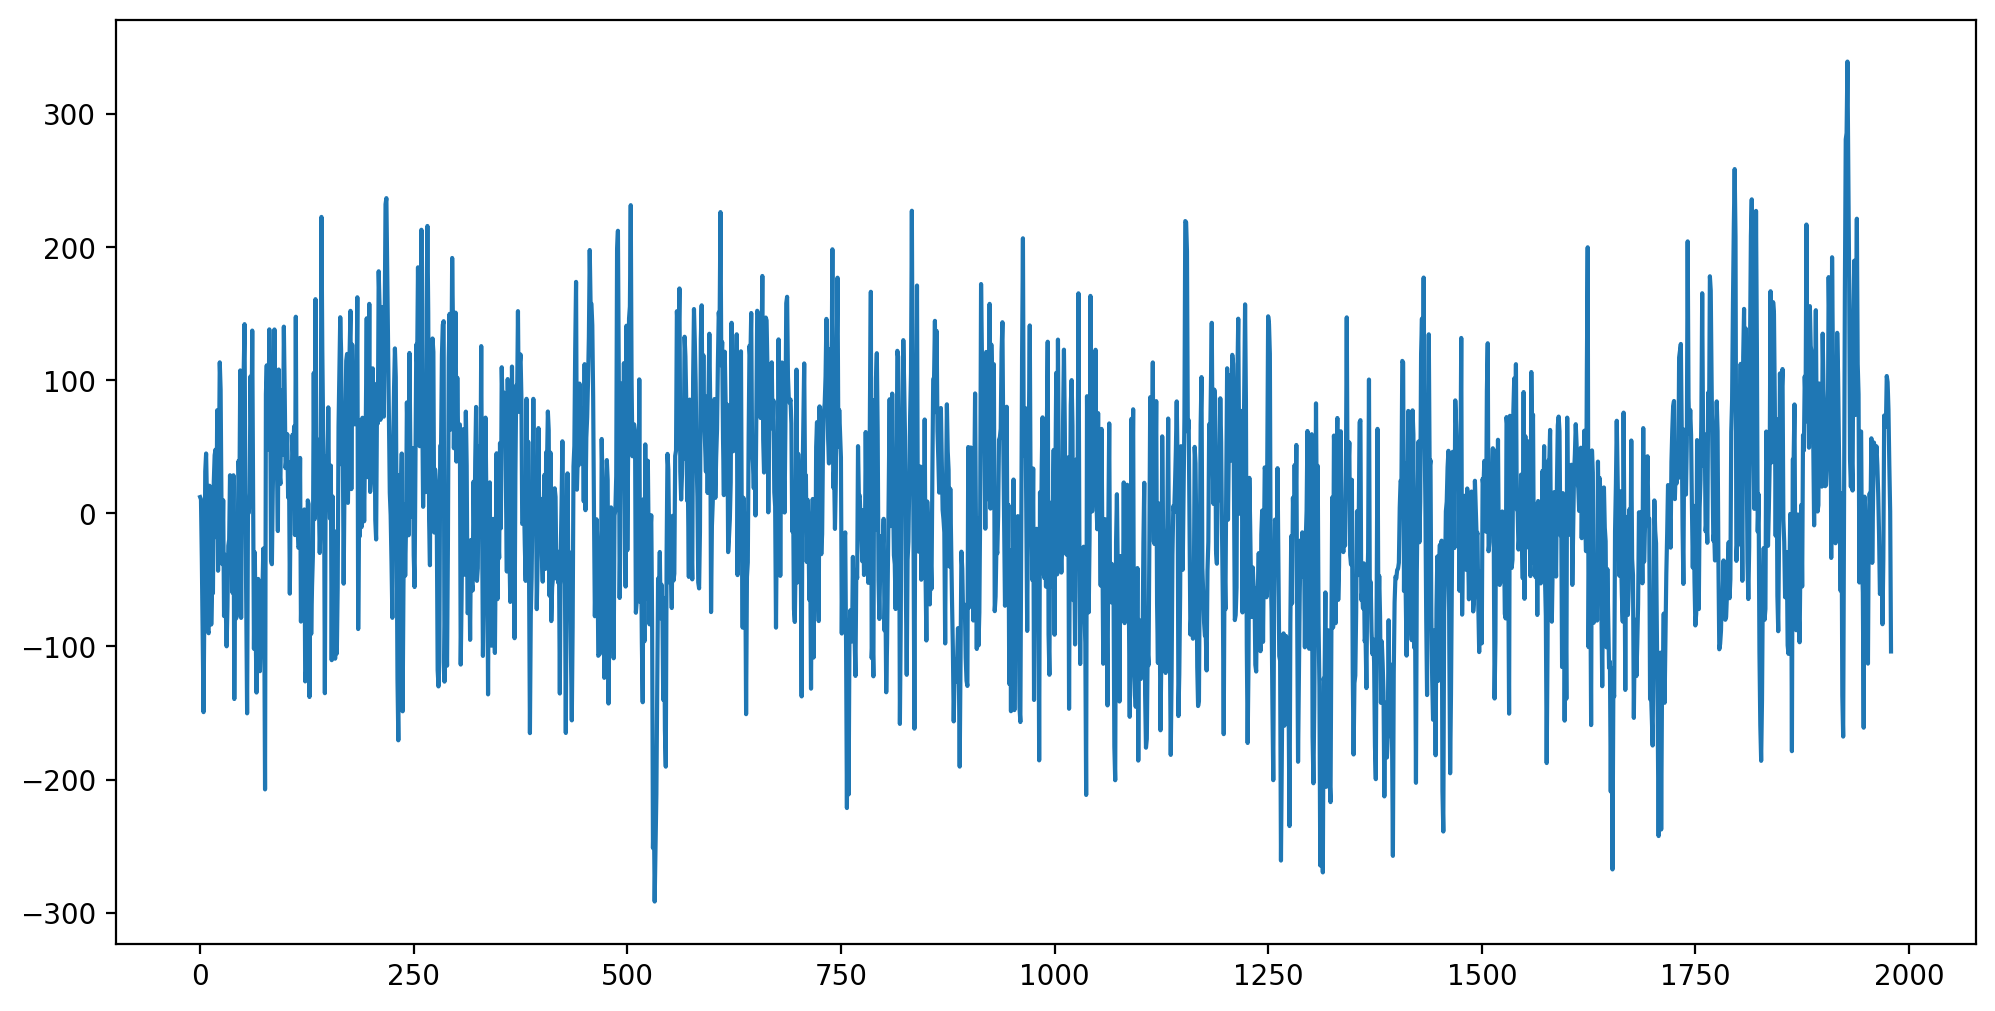

PCA - TCW  6


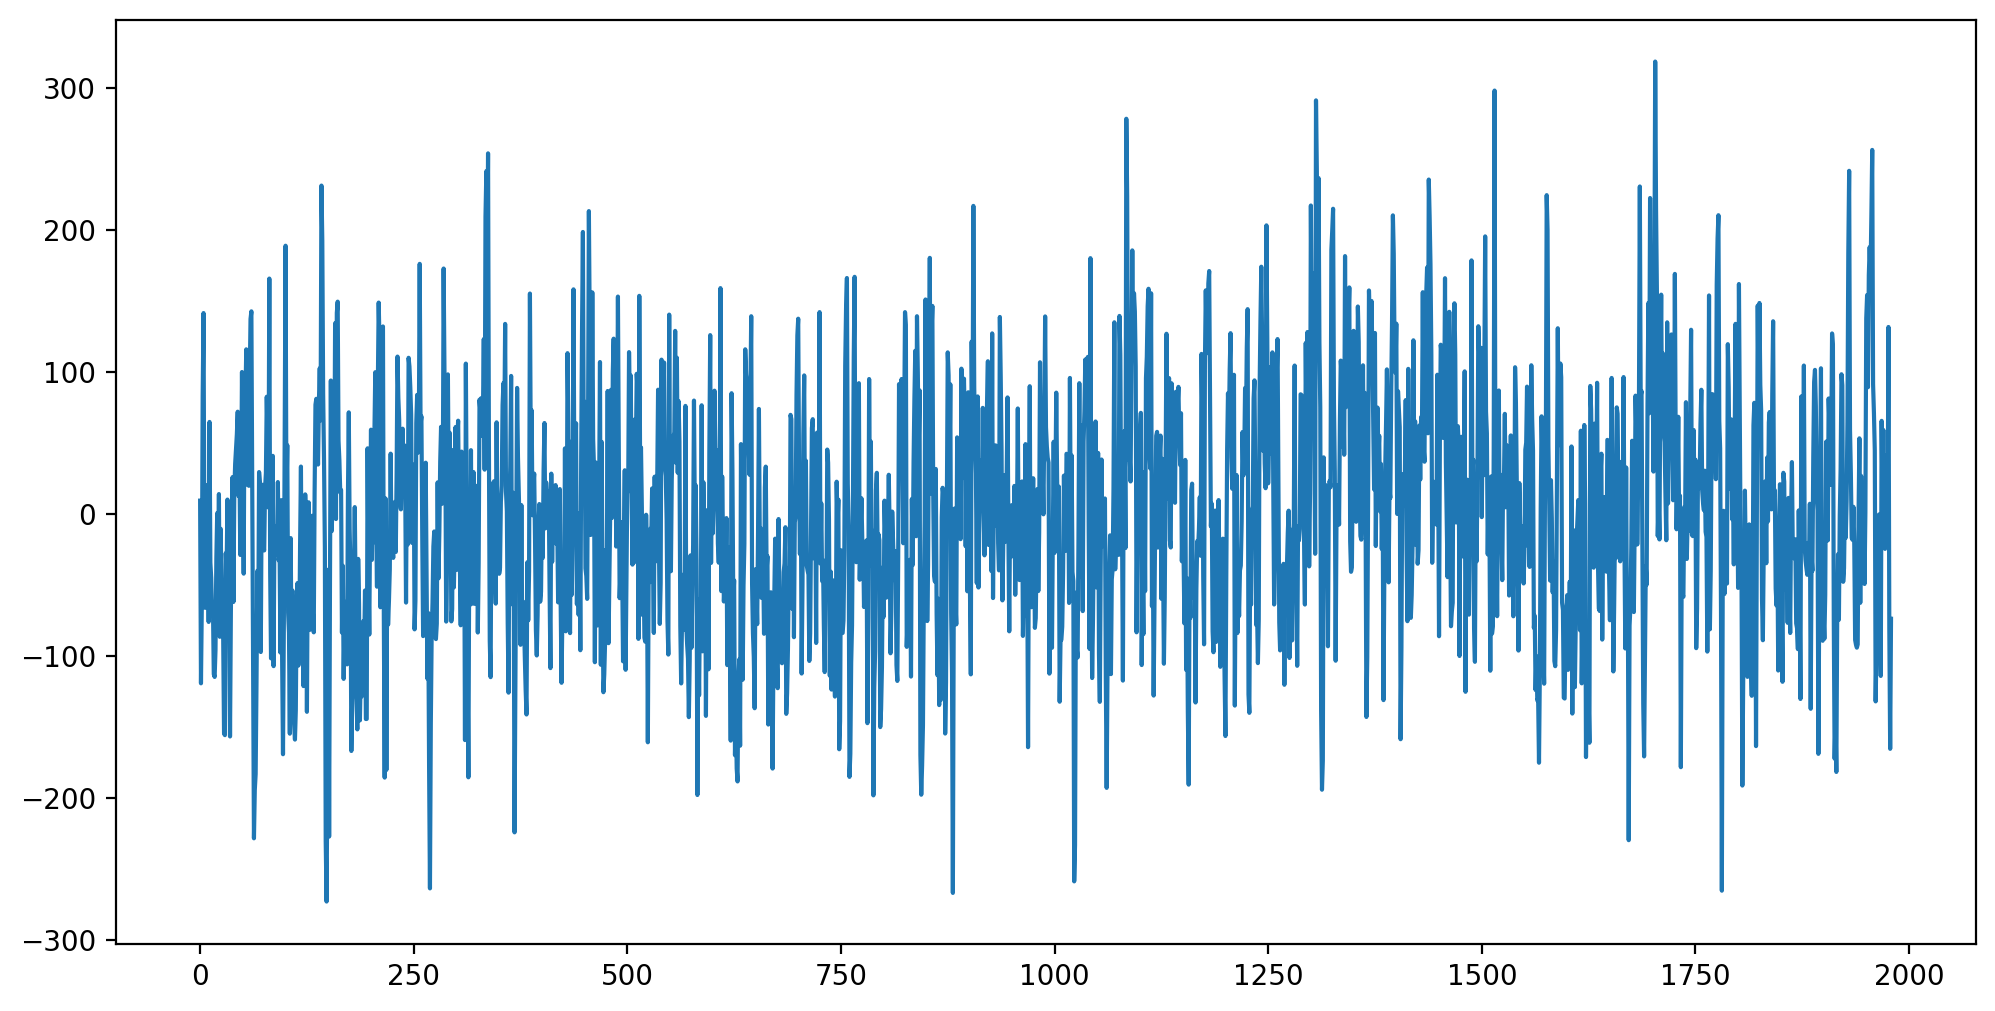

In [67]:
print(X_proj.shape)
for i in range(6):
    print('PCA - temperature ', str(i+1))
    plt.plot(X_proj[:,i])
    plt.show()
for i in range(6):
    print('PCA - TCW ', str(i+1))

    plt.plot(Y_proj[:,i])
    plt.show()

## Do Linear Regression of $\tilde{Y} = [\mathbf{y_1}, \mathbf{y_2}, \mathbf{y_3}, \mathbf{y_4}]$ on $\tilde{X} = [\mathbf{x_1}, \mathbf{x_2}, \mathbf{x_3}, \mathbf{x_4}]$. This means that I am regressing each y_i on all x_j. There will be 4 intercepts + 4 * 4 coefficients

In [9]:
# Fit regression: Predict log(TPW) from temperature PCs
reg = LinearRegression()
reg.fit(X_reduced, Y_reduced)  # X_pca (N_t, 4) → Y_pca (N_t, 4)

# Predictions
Y_pred = reg.predict(X_reduced)

# Regression coefficients
print("Regression Coefficients:\n", reg.coef_)

# Compute R² for goodness of fit
r2 = r2_score(Y_reduced, Y_pred)
print(f"R² Score: {r2:.3f}")


Regression Coefficients:
 [[ 5.5349428e-02  3.0212708e-02 -1.8705057e-02  2.1305807e-02]
 [ 1.1450490e-03 -3.4780167e-02 -3.5229590e-02 -8.9543536e-03]
 [ 8.6024124e-04 -1.6776234e-02  5.9103809e-02 -5.5079730e-03]
 [ 8.0426704e-05  4.0728464e-03  7.0014484e-03  1.1222556e-02]]
R² Score: 0.705


## Resconstruct: since $\tilde{Y} = Y\cdot V$, we have $Y \approx \tilde{Y} V^T$

In [10]:
Y_reconstructed = np.exp( np.dot(Y_pred, pca_Y.components_) + np.log(Y).mean(axis=0) )

In [11]:
areas = ds_area.areacella.values
area_weights_flat = areas.reshape(1, N_lat * N_lon)
total_area_float = np.sum(area_weights_flat)

In [12]:
global_mean_TPW_pred = np.sum(Y_reconstructed * area_weights_flat, axis=1) / total_area_float

In [13]:
r2_global_mean = r2_score(array_prw_ts, global_mean_TPW_pred)
r2_global_mean

0.8000404547996728

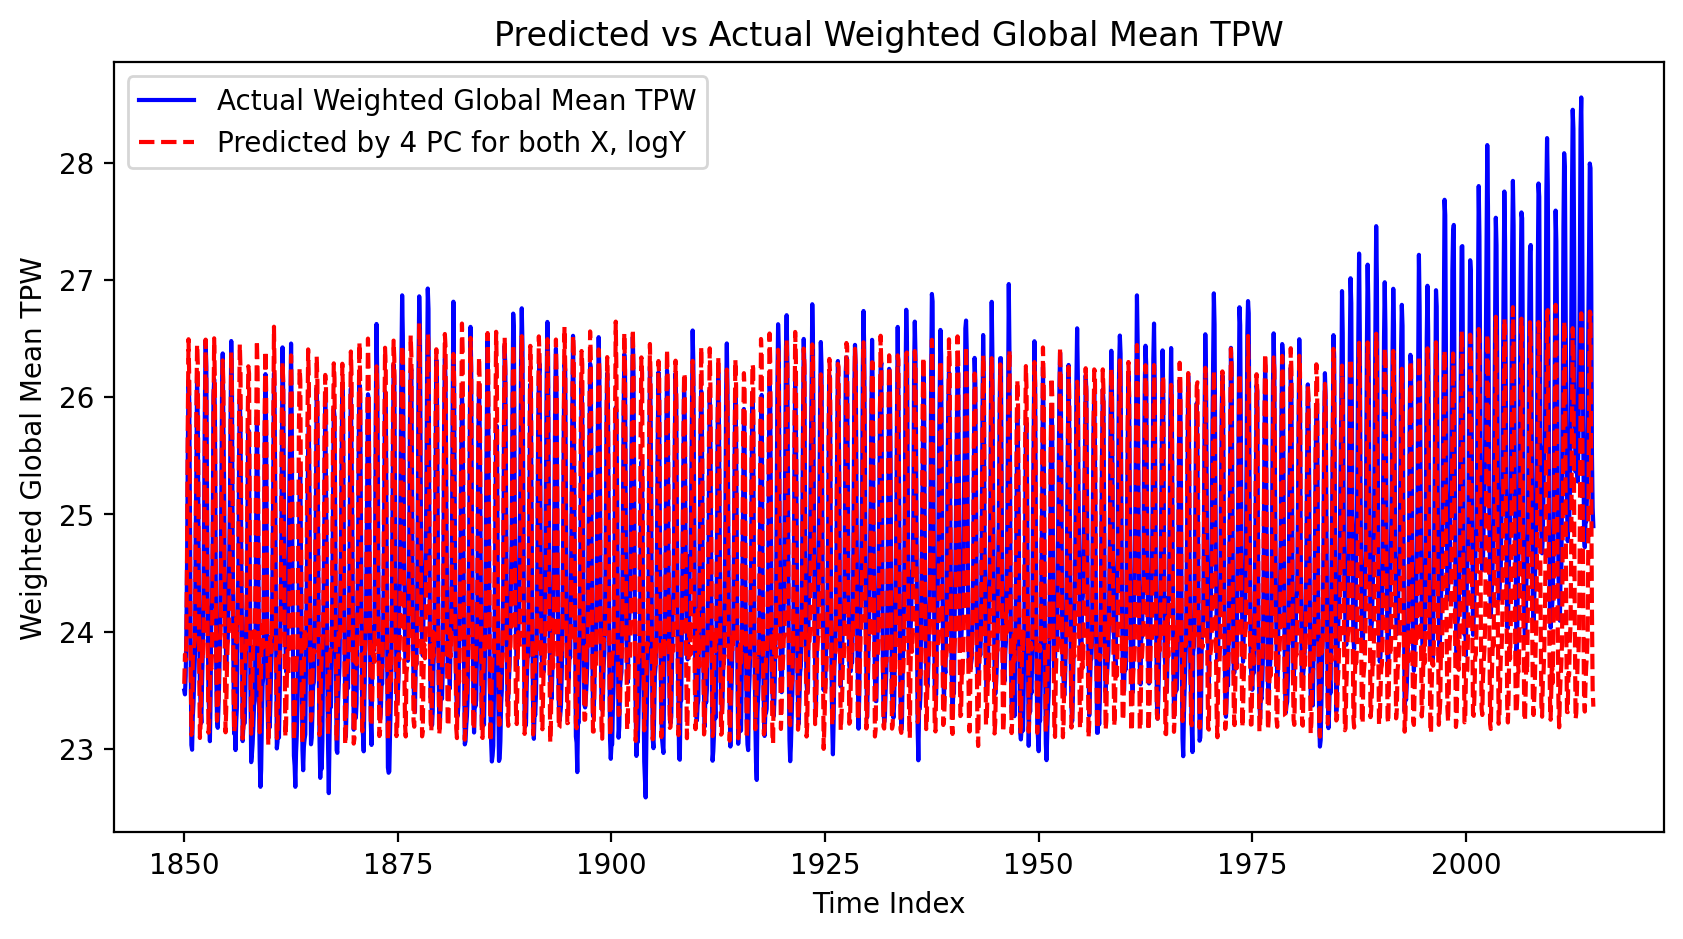

In [ ]:
plt.figure(figsize=(10, 5))
l, r = 1000, 1200
plt.plot(time[l:r], array_prw_ts[l: r], label="Actual Weighted Global Mean TPW", color='b')
plt.plot(time[l:r], global_mean_TPW_pred[l: r], label="Predicted by 4 PC for both X, logY", linestyle="dashed", color='r')

plt.xlabel("Time Index")
plt.ylabel("Weighted Global Mean TPW")
plt.title("Predicted vs Actual Weighted Global Mean TPW")
plt.legend()
plt.show()

## What if using 1 PC?

In [15]:
# Apply PCA
pca_X_1 = PCA(n_components=1)  # Retain top 50 components
X_reduced_1 = pca_X_1.fit_transform(X_centered)
pca_Y_1 = PCA(n_components=1)  # Retain top 50 components
Y_reduced_1 = pca_Y_1.fit_transform(Y_centered)

# Explained variance
explained_variance_X = pca_X.explained_variance_ratio_.sum()
print(f"Total variance explained by top 1 PCs (X): {explained_variance_X:.2%}")
explained_variance_Y = pca_Y.explained_variance_ratio_.sum()
print(f"Total variance explained by top 1 PCs (Log(Y)): {explained_variance_Y:.2%}")

# Principal component time series (X_reduced) now has shape (N_t, 1)
# Fit regression: Predict log(TPW) from temperature PCs
reg = LinearRegression()
reg.fit(X_reduced_1, Y_reduced_1)  # X_pca (N_t, 1) → Y_pca (N_t, 1)

# Predictions
Y_pred_1 = reg.predict(X_reduced_1)
# Regression coefficients
print("Regression Coefficient (BETA):\n", reg.coef_)

Total variance explained by top 1 PCs (X): 95.38%
Total variance explained by top 1 PCs (Log(Y)): 89.78%
Regression Coefficient (BETA):
 [[0.05534944]]


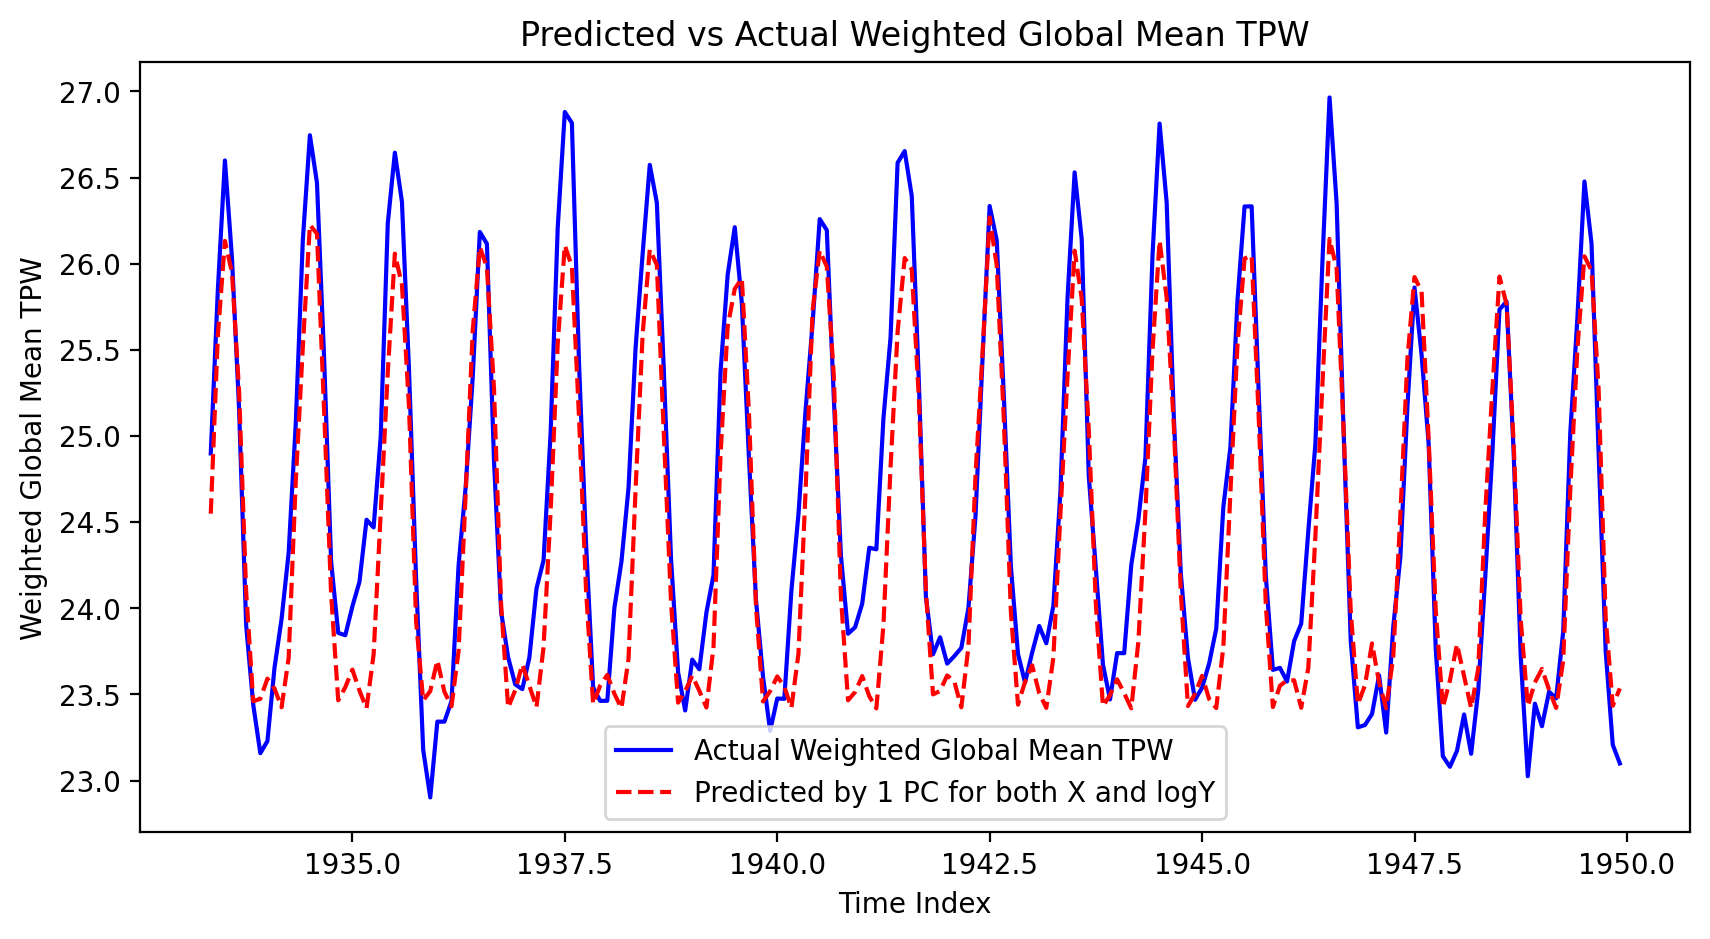

In [ ]:
Y_reconstructed_1 = np.exp( np.dot(Y_pred_1, pca_Y_1.components_) + np.log(Y).mean(axis=0) )
global_mean_TPW_pred_1 = np.sum(Y_reconstructed_1 * area_weights_flat, axis=1) / total_area_float
plt.figure(figsize=(10, 5))

l, r = 1000, 1200
plt.plot(time[l:r], array_prw_ts[l: r], label="Actual Weighted Global Mean TPW", color='b')
plt.plot(time[l:r], global_mean_TPW_pred_1[l: r], label="Predicted by 1 PC for both X and logY", linestyle="dashed", color='r')

plt.xlabel("Time Index")
plt.ylabel("Weighted Global Mean TPW")
plt.title("Predicted vs Actual Weighted Global Mean TPW")
plt.legend()
plt.show()

In [17]:
X_recent = X[1620:]
Y_recent = Y[1620:]
X_recent_centered = X_recent - X_recent.mean(axis=0)
Y_recent_centered = np.log(Y_recent) - np.log(Y_recent).mean(axis=0)
# Apply PCA
pca_X_rec = PCA(n_components=1)  # Retain top 50 components
X_reduced_rec = pca_X_rec.fit_transform(X_recent_centered)
pca_Y_rec = PCA(n_components=1)  # Retain top 50 components
Y_reduced_rec = pca_Y_rec.fit_transform(Y_recent_centered)
# Explained variance
explained_variance_X_rec = pca_X_rec.explained_variance_ratio_.sum()
print(f"Total variance explained by top 1 PCs (X): {explained_variance_X_rec:.2%}")
explained_variance_Y_rec = pca_Y_rec.explained_variance_ratio_.sum()
print(f"Total variance explained by top 1 PCs (Log(Y)): {explained_variance_Y_rec:.2%}")
# Principal component time series (X_reduced) now has shape (N_t, 4)
# explained_variance_ratio_X_rec = pca_X_rec.explained_variance_ratio_
# cumulative_variance_X_rec = np.cumsum(explained_variance_ratio_X_rec)

# explained_variance_ratio_Y_rec = pca_Y_rec.explained_variance_ratio_
# cumulative_variance_Y_rec = np.cumsum(explained_variance_ratio_Y_rec)

# plt.figure(figsize=(10, 5))
# plt.bar(range(1, 5), explained_variance_ratio_X_rec[:4], alpha=0.5, label="Individual X Variance")
# plt.plot(range(1, 5), cumulative_variance_X_rec[:4], marker='o', linestyle='-', color='r', label="Cumulative X Variance")
# plt.bar(range(1, 5), explained_variance_ratio_Y_rec[:4], alpha=0.5, label="Individual Y Variance")
# plt.plot(range(1, 5), cumulative_variance_Y_rec[:4], marker='x', linestyle='-.', color='b', label="Cumulative Y Variance")

# plt.xlabel("Number of Principal Components")
# plt.ylabel("Explained Variance Ratio")
# plt.title("Explained Variance of Principal Components")
# plt.legend()
# plt.show()

Total variance explained by top 1 PCs (X): 87.83%
Total variance explained by top 1 PCs (Log(Y)): 83.83%


In [22]:
reg = LinearRegression()
reg.fit(X_reduced_rec, Y_reduced_rec)  # X_pca (N_t, 1) → Y_pca (N_t, 1)

# Predictions
Y_pred_rec= reg.predict(X_reduced_rec)
# Regression coefficients
print("Regression Coefficient (BETA):\n", reg.coef_)

Regression Coefficient (BETA):
 [[-0.05735526]]


## Simply reverting the sign of the Principle component then we get the positive beta with the same absolute value.
## Though we are here only using the data after 1985, the prediction still does not catch the general trend. It probably means that PCA captures the local oscillations well but treated the general increasing trend as "noise."

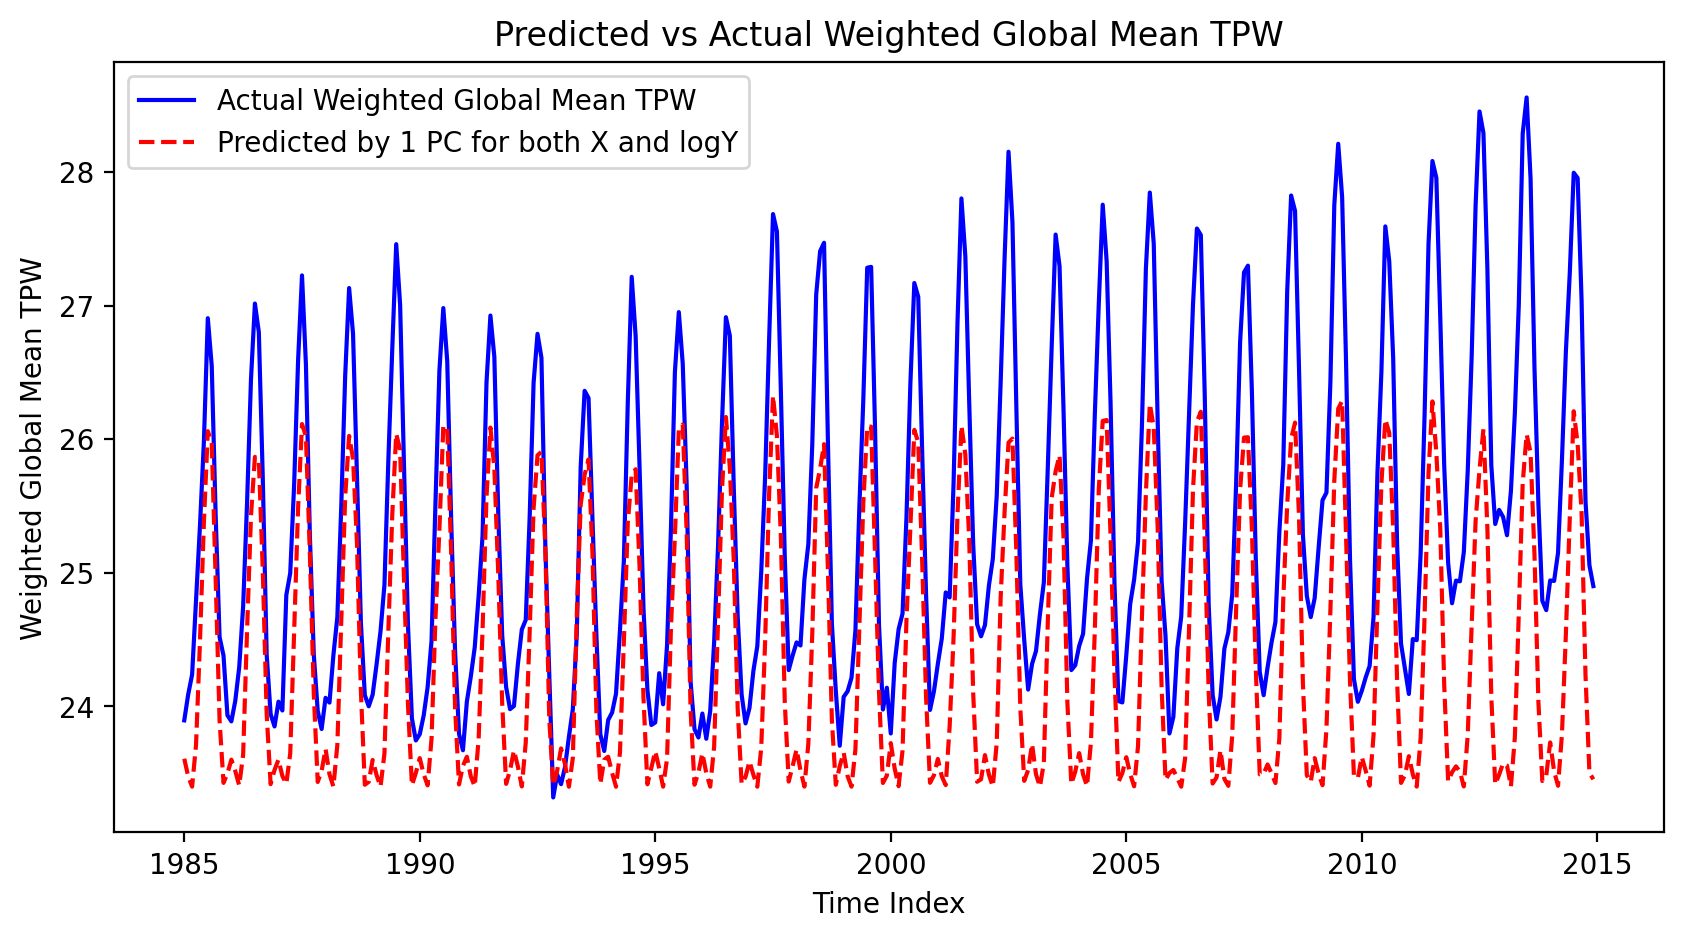

In [23]:
Y_reconstructed_rec = np.exp( np.dot(Y_pred_rec, pca_Y_rec.components_) + np.log(Y).mean(axis=0) )
global_mean_TPW_pred_rec = np.sum(Y_reconstructed_rec * area_weights_flat, axis=1) / total_area_float
plt.figure(figsize=(10, 5))
# l, r = 1000, 1200
plt.plot(time[1620:], array_prw_ts[1620:], label="Actual Weighted Global Mean TPW", color='b')
plt.plot(time[1620:], global_mean_TPW_pred_rec, label="Predicted by 1 PC for both X and logY", linestyle="dashed", color='r')

plt.xlabel("Time Index")
plt.ylabel("Weighted Global Mean TPW")
plt.title("Predicted vs Actual Weighted Global Mean TPW")
plt.legend()
plt.show()